# US Airline Flight Routes and Fares 1993-2024

## Business Understanding
This analysis aims to identify the key factors that influence airline fare prices using a dataset containing detailed information on U.S. domestic flight routes from 1993 to 2024. The insights derived from this analysis will help airlines, travel agencies, and policy makers optimize pricing strategies, improve route planning, and better understand competitive dynamics in the air travel market.

## Data Understanding
The dataset provides comprehensive information on airline flight routes, fares, and passenger volumes within the United States over a span of three decades. It includes metrics such as origin and destination cities and airports, distances between airports, number of passengers, and fare details segmented by different carriers (including the largest carrier and the lowest fare carrier). This rich set of features enables an in-depth analysis of air travel trends, pricing behavior, and market share dynamics.


### Data Dictionary
- `tbl`: Table identifier
- `year`: Year of the data record
- `quarter`: Quarter of the year (1–4)
- `citymarketid_1`: Origin city market ID
- `citymarketid_2`: Destination city market ID
- `city1`: Origin city name
- `city2`: Destination city name
- `airportid_1`: Origin airport ID
- `airportid_2`: Destination airport ID
- `airport_1`: Origin airport code
- `airport_2`: Destination airport code
- `nsmiles`: Distance between airports in miles
- `passengers`: Number of passengers
- `fare`: Average fare
- `carrier_lg`: Code for the largest carrier by passengers
- `large_ms`: Market share of the largest carrier
- `fare_lg`: Average fare of the largest carrier
- `carrier_low`: Code for the lowest fare carrier
- `lf_ms`: Market share of the lowest fare carrier
- `fare_low`: Lowest fare
- `Geocoded_City1`: Geocoded coordinates for the origin city
- `Geocoded_City2`: Geocoded coordinates for the destination city
- `tbl1apk`: Unique identifier for the route

In [1]:
# Remember to install ace_tools_open and pmdarima
# pip install ace_tools_open pmdarima in terminal and restart kernel

# Standard library imports
import os
import warnings
import time
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd
from collections import Counter
from itertools import chain

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from xgboost import XGBRegressor


# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# SHAP
import shap

# Joblib
import joblib

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Set random seed for reproducibility
np.random.seed(42)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set_palette("viridis")

## Data Loading

Let's load the dataset and perform an initial exploration to understand its structure and contents.

In [2]:
# Download dataset
filename = 'us-airline-flight-routes-and-fares-1993-2024.zip'
if not os.path.exists(filename):
  !curl -L -o us-airline-flight-routes-and-fares-1993-2024.zip \
    https://www.kaggle.com/api/v1/datasets/download/bhavikjikadara/us-airline-flight-routes-and-fares-1993-2024

# Load the dataset
data = pd.read_csv(filename)

# Display basic information
print(f"Dataset shape: {data.shape}")
print("\nFirst 5 rows:")
display(data.head())

# Basic statistics
print("\nBasic statistics:")
display(data.describe(include='all'))

# Check for missing values
print("\nMissing values per column:")
display(data.isnull().sum().sort_values(ascending=False))

# Check data types
print("\nData types:")
display(data.dtypes)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 13.0M  100 13.0M    0     0  18.2M      0 --:--:-- --:--:-- --:--:-- 18.2M
Dataset shape: (245955, 23)

First 5 rows:


,tbl,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,airportid_1,airportid_2,airport_1,airport_2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2,tbl1apk
0,Table1a,2021,3,30135,33195,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",10135,14112,ABE,PIE,970,180,81.43,G4,1.0000,81.43,G4,1.0000,81.43,NaN,NaN,202131013514112ABEPIE
1,Table1a,2021,3,30135,33195,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",10135,15304,ABE,TPA,970,19,208.93,DL,0.4659,219.98,UA,0.1193,154.11,NaN,NaN,202131013515304ABETPA
2,Table1a,2021,3,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",10140,11259,ABQ,DAL,580,204,184.56,WN,0.9968,184.44,WN,0.9968,184.44,NaN,NaN,202131014011259ABQDAL
3,Table1a,2021,3,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",10140,11298,ABQ,DFW,580,264,182.64,AA,0.9774,183.09,AA,0.9774,183.09,NaN,NaN,202131014011298ABQDFW
4,Table1a,2021,3,30140,30466,"Albuquerque, NM","Phoenix, AZ",10140,14107,ABQ,PHX,328,398,177.11,WN,0.6061,184.49,AA,0.3939,165.77,NaN,NaN,202131014014107ABQPHX



Basic statistics:


,tbl,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,airportid_1,airportid_2,airport_1,airport_2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2,tbl1apk
count,245955,245955.000000,245955.000000,245955.000000,245955.000000,245955,245955,245955.000000,245955.000000,245955,245955,245955.000000,245955.000000,245955.000000,244415,244415.000000,244415.000000,244343,244343.000000,244343.000000,206749,206749,245955
unique,2,NaN,NaN,NaN,NaN,141,128,NaN,NaN,187,173,NaN,NaN,NaN,67,NaN,NaN,71,NaN,NaN,238,207,245955
top,Table 1a,NaN,NaN,NaN,NaN,"Los Angeles, CA (Metropolitan Area)","New York City, NY (Metropolitan Area)",NaN,NaN,ORD,DCA,NaN,NaN,NaN,WN,NaN,NaN,WN,NaN,NaN,"Los Angeles, CA (Metropolitan Area)\n(34.052238, -118.243344)","New York City, NY (Metropolitan Area)\n(40.123164, -75.333718)",202411541215304TYSTPA
freq,200897,NaN,NaN,NaN,NaN,26055,36913,NaN,NaN,8819,10268,NaN,NaN,NaN,58999,NaN,NaN,56027,NaN,NaN,21028,30688,1
mean,NaN,2008.524124,2.479153,31556.430201,32180.117086,NaN,NaN,12437.099986,13249.889525,NaN,NaN,1189.812319,299.476795,218.979587,NaN,0.665252,218.710963,NaN,0.450438,190.675939,NaN,NaN,NaN
std,NaN,8.703364,1.122149,1089.872880,1232.464184,NaN,NaN,1431.665257,1425.810159,NaN,NaN,703.143472,511.389486,82.372486,NaN,0.224635,84.674363,NaN,0.332669,73.577694,NaN,NaN,NaN
min,NaN,1993.000000,1.000000,30135.000000,30189.000000,NaN,NaN,10135.000000,10466.000000,NaN,NaN,109.000000,0.000000,50.000000,NaN,0.003800,50.000000,NaN,0.010000,50.000000,NaN,NaN,NaN
25%,NaN,2001.000000,1.000000,30721.000000,30994.000000,NaN,NaN,11193.000000,12197.000000,NaN,NaN,626.000000,21.000000,164.620000,NaN,0.480000,161.500000,NaN,0.158000,140.060000,NaN,NaN,NaN
50%,NaN,2008.000000,2.000000,31423.000000,32211.000000,NaN,NaN,12266.000000,13303.000000,NaN,NaN,1023.000000,113.000000,209.320000,NaN,0.652400,208.030000,NaN,0.360000,181.630000,NaN,NaN,NaN
75%,NaN,2016.000000,3.000000,32467.000000,33192.000000,NaN,NaN,13487.000000,14679.000000,NaN,NaN,1736.000000,339.000000,262.890000,NaN,0.871900,263.640000,NaN,0.750000,230.040000,NaN,NaN,NaN



Missing values per column:


,0
Geocoded_City1,39206
Geocoded_City2,39206
carrier_low,1612
lf_ms,1612
fare_low,1612
carrier_lg,1540
fare_lg,1540
large_ms,1540
city2,0
citymarketid_2,0



Data types:


,0
tbl,object
Year,int64
quarter,int64
citymarketid_1,int64
citymarketid_2,int64
city1,object
city2,object
airportid_1,int64
airportid_2,int64
airport_1,object


## Data Cleaning & Mapping Logic for Airline Dataset

This section handles critical preprocessing tasks including value imputation, feature generation, outlier removal, and mapping of airports to airlines. These transformations are essential for generating robust inputs for modeling and analysis.

---

### Section 1: Airport-to-Airline Mapping

A predefined dictionary maps major U.S. airport codes to their dominant or serving airlines (e.g., `LAX` → American, Delta, United). This mapping supports multi-airline detection from airport routes.

### Section 2: Mapping Metropolitan Cities to Airport Codes

Defines `map_metropolitan_to_airport()` function to convert broad metro area city names into representative airport codes (e.g., `New York` → `JFK`, `Los Angeles` → `LAX`). This ensures city-level route consistency in cases of ambiguous airport naming.

### Section 3: Airport Code to Airline List Function

Defines `map_airlines()` to convert an individual airport code into a list of its serving airlines using the mapping defined in Section 1.

### Section 4: `clean_airline_data()` – Core Cleaning Pipeline

This function applies a comprehensive series of cleaning operations:

- **Step 1: Missing Values**  
  Drops columns with >50% missing data, then removes rows with nulls in required columns (`fare`, `passengers`, `nsmiles`, etc.).

- **Step 2: Column Removal**  
  Drops known irrelevant columns like `'tbl'` and `'tbl1apk'`.

- **Step 3: Type Conversions**  
  Ensures numeric consistency for year, quarter, passenger counts, and distances (`nsmiles`).

- **Step 4: Feature Engineering**  
  Adds derived fields such as:
  - `fare_per_mile`
  - `passengers_per_mile`
  - `fare_per_passenger`
  - `revenue = fare × passengers`
  - `year_quarter` (for grouping and temporal sorting)
  - `period` (as `pd.PeriodIndex` for quarterly operations)

- **Step 5: Apply Metro-to-Airport Mapping**  
  Cleans ambiguous airport entries using the metro-to-airport logic defined earlier.

- **Step 6: Airline Assignment Based on Routes**  
  Enriches the dataset with:
  - `airlines_1` and `airlines_2` (serving airlines for each airport)
  - `possible_airlines` (combined and deduplicated set of all potential carriers for a given_


In [3]:
# Mapping: airport codes to airlines

print("\n\nSection 1: Defining airport-to-airline mappings")
airport_airline_map = {
    'DFW': ['American Airlines'],
    'CLT': ['American Airlines'],
    'ORD': ['American Airlines', 'United Airlines'],
    'LAX': ['American Airlines', 'Delta Air Lines', 'United Airlines'],
    'MIA': ['American Airlines'],
    'JFK': ['American Airlines', 'Delta Air Lines'],
    'LGA': ['American Airlines', 'Delta Air Lines'],
    'PHL': ['American Airlines'],
    'PHX': ['American Airlines', 'Southwest Airlines'],
    'DCA': ['American Airlines'],
    'ATL': ['Delta Air Lines'],
    'BOS': ['Delta Air Lines'],
    'DTW': ['Delta Air Lines'],
    'MSP': ['Delta Air Lines'],
    'SLC': ['Delta Air Lines'],
    'SEA': ['Delta Air Lines'],
    'DEN': ['United Airlines', 'Southwest Airlines'],
    'IAH': ['United Airlines'],
    'EWR': ['United Airlines'],
    'SFO': ['United Airlines'],
    'IAD': ['United Airlines'],
    'BWI': ['Southwest Airlines'],
    'MDW': ['Southwest Airlines'],
    'DAL': ['Southwest Airlines'],
    'HOU': ['Southwest Airlines'],
    'LAS': ['Southwest Airlines'],
    'OAK': ['Southwest Airlines'],
    'MCO': ['Southwest Airlines'],
}

print("\n\nSection 2: Mapping metropolitan city names to major airport codes")
def map_metropolitan_to_airport(city_name):
    if "Miami" in city_name:
        return "MIA"
    elif "New York" in city_name:
        return "JFK"  # or LGA
    elif "Boston" in city_name:
        return "BOS"
    elif "San Francisco" in city_name:
        return "SFO"
    elif "Los Angeles" in city_name:
        return "LAX"
    elif "Norfolk" in city_name:
        return "DCA"
    elif "Cleveland" in city_name:
        return "ORD"  # No Cleveland hub, ORD as major connection
    elif "Washington" in city_name:
        return "DCA"  # or IAD for United
    elif "Atlanta" in city_name:
        return "ATL"
    elif "Tampa" in city_name:
        return "MCO"  # or TPA if exact, but you can keep MCO for SWA logic
    else:
        return None

print("\n\nSection 3: Mapping airport codes to airline lists")
def map_airlines(airport_code):
    return airport_airline_map.get(airport_code, [])

print("\n\nSection 4: Cleaning airline dataset")
def clean_airline_data(df):
    """Clean and preprocess the airline fare dataset for predictive modeling."""

    df_clean = df.copy()

    print("\nStep 1: Handling missing values")
    missing_percent = df_clean.isnull().mean() * 100
    cols_to_drop = missing_percent[missing_percent > 50].index.tolist()
    df_clean = df_clean.drop(columns=cols_to_drop)
    print(f"Dropped columns with >50% missing values: {cols_to_drop}")

    initial_rows = df_clean.shape[0]
    required_cols = ['fare', 'passengers', 'nsmiles', 'quarter', 'Year']
    df_clean = df_clean.dropna(subset=required_cols)
    df_clean = df_clean.drop_duplicates()

    cols_to_remove = ['tbl', 'tbl1apk']
    for col in cols_to_remove:
        if col in df_clean.columns:
            df_clean = df_clean.drop(col, axis=1)
            print(f"Dropped column: {col}")

    dropped_rows = initial_rows - df_clean.shape[0]
    print(f"\nDropped {dropped_rows} rows with missing values")
    print(f"Shape after dropping NaN values: {df_clean.shape}")

    print("\nStep 2: Handling outliers - defining function")
    def remove_outliers_by_year(df, column, group_col='Year'):
        def iqr_filter(sub_df):
            if len(sub_df) < 100:
                return sub_df
            Q1 = sub_df[column].quantile(0.25)
            Q3 = sub_df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            return sub_df[(sub_df[column] >= lower) & (sub_df[column] <= upper)]
        return df.groupby(group_col, group_keys=False).apply(iqr_filter)

    print("\nStep 3: Converting data types")
    if 'Year' in df_clean.columns:
        df_clean['Year'] = df_clean['Year'].astype(int)
    if 'quarter' in df_clean.columns:
        df_clean['quarter'] = df_clean['quarter'].astype(int)
    if 'passengers' in df_clean.columns:
        df_clean['passengers'] = df_clean['passengers'].astype(int)
    if 'nsmiles' in df_clean.columns:
        df_clean['nsmiles'] = df_clean['nsmiles'].astype(float)

    print("\nStep 4: Creating new features")
    if 'fare' in df_clean.columns and 'nsmiles' in df_clean.columns:
        df_clean['fare_per_mile'] = df_clean['fare'] / (df_clean['nsmiles'] + 1e-5)  # Add epsilon to avoid division by zero
    if 'passengers' in df_clean.columns and 'nsmiles' in df_clean.columns:
        df_clean['passengers_per_mile'] = df_clean['passengers'] / (df_clean['nsmiles'] + 1e-5)
    if 'passengers' in df_clean.columns:
        df_clean['fare_per_passenger'] = df_clean['fare_per_mile'] / (df_clean['passengers_per_mile'] + 1e-5)

    df_clean['revenue'] = df_clean['passengers'] * df_clean['fare']
    df_clean['year_quarter'] = df_clean['Year'].astype(str) + 'Q' + df_clean['quarter'].astype(str)
    df_clean['year_num'] = df_clean['Year'].astype(int)
    df_clean['quarter_num'] = df_clean['quarter'].astype(int)

    ordered_quarters = (
        df_clean[['year_quarter', 'year_num', 'quarter_num']]
        .drop_duplicates()
        .sort_values(by=['year_num', 'quarter_num'])['year_quarter']
        .tolist()
    )

    df_clean['year_quarter'] = pd.Categorical(df_clean['year_quarter'], categories=ordered_quarters, ordered=True)

    if 'period' not in df_clean.columns:
        df_clean['period'] = pd.PeriodIndex(year=df_clean['Year'], quarter=df_clean['quarter'], freq='Q')

    print("\nStep 5: Mapping metropolitan cities to airports")
    if 'airport_1' in df_clean.columns and 'city1' in df_clean.columns:
        df_clean['airport_1'] = df_clean.apply(
            lambda row: map_metropolitan_to_airport(row['city1']) if 'Metropolitan' in str(row['city1']) else row['airport_1'],
            axis=1
        )
    if 'airport_2' in df_clean.columns and 'city2' in df_clean.columns:
        df_clean['airport_2'] = df_clean.apply(
            lambda row: map_metropolitan_to_airport(row['city2']) if 'Metropolitan' in str(row['city2']) else row['airport_2'],
            axis=1
        )

    print("\nStep 6: Mapping airlines from airport codes")
    if 'airport_1' in df_clean.columns:
        df_clean['airlines_1'] = df_clean['airport_1'].apply(map_airlines)
    if 'airport_2' in df_clean.columns:
        df_clean['airlines_2'] = df_clean['airport_2'].apply(map_airlines)

    df_clean['possible_airlines'] = [
        list(set(a1 + a2)) for a1, a2 in zip(df_clean['airlines_1'], df_clean['airlines_2'])
    ]

    print("\nStep 7: Removing outliers from selected numeric columns")
    numeric_cols = [col for col in ['fare', 'passengers', 'nsmiles', 'fare_per_mile', 'passengers_per_mile', 'revenue'] if col in df_clean.columns]
    for column in numeric_cols:
        if column not in ['fare', 'revenue', 'passengers', 'Year', 'year_quarter', 'year_num']:
            df_clean = remove_outliers_by_year(df_clean, column)

    print("Shape after removing outliers:", df_clean.shape)
    return df_clean

print("\n\nSection 5: Applying cleaning function to raw data")
df_clean = clean_airline_data(data)

print("\n\nSection 6: Previewing cleaned data and extracting metropolitan city info")
print("\nSample of cleaned dataset:")
display(df_clean[['airport_1', 'airport_2', 'year_quarter', 'passengers', 'fare', 'revenue']].head())

if 'city1' in df_clean.columns:
    metropolitan_city1 = df_clean.loc[df_clean['city1'].str.contains('Metropolitan', case=False, na=False), 'city1'].unique()
else:
    metropolitan_city1 = []

if 'city2' in df_clean.columns:
    metropolitan_city2 = df_clean.loc[df_clean['city2'].str.contains('Metropolitan', case=False, na=False), 'city2'].unique()
else:
    metropolitan_city2 = []

metropolitan_cities_set = set(metropolitan_city1).union(set(metropolitan_city2))

print("\nUnique set of Metropolitan cities:")
print(metropolitan_cities_set, len(metropolitan_cities_set))

print("\nCleaned dataset info:")
df_clean.info()
display(df_clean.head())



Section 1: Defining airport-to-airline mappings


Section 2: Mapping metropolitan city names to major airport codes


Section 3: Mapping airport codes to airline lists


Section 4: Cleaning airline dataset


Section 5: Applying cleaning function to raw data

Step 1: Handling missing values
Dropped columns with >50% missing values: []
Dropped column: tbl
Dropped column: tbl1apk

Dropped 0 rows with missing values
Shape after dropping NaN values: (245955, 21)

Step 2: Handling outliers - defining function

Step 3: Converting data types

Step 4: Creating new features

Step 5: Mapping metropolitan cities to airports

Step 6: Mapping airlines from airport codes

Step 7: Removing outliers from selected numeric columns
Shape after removing outliers: (204203, 32)


Section 6: Previewing cleaned data and extracting metropolitan city info

Sample of cleaned dataset:


,airport_1,airport_2,year_quarter,passengers,fare,revenue
5923,HSV,DCA,1993Q4,21,242.76,5097.96
5930,IAH,SFO,1993Q1,51,272.66,13905.66
5961,BHM,LAX,1993Q1,2,290.64,581.28
5969,JFK,RIC,1993Q1,4,173.52,694.08
5983,SAN,DCA,1993Q1,266,290.94,77390.04



Unique set of Metropolitan cities:
{'Washington, DC (Metropolitan Area)', 'Tampa, FL (Metropolitan Area)', 'Cleveland, OH (Metropolitan Area)', 'Los Angeles, CA (Metropolitan Area)', 'Norfolk, VA (Metropolitan Area)', 'Boston, MA (Metropolitan Area)', 'Atlanta, GA (Metropolitan Area)', 'New York City, NY (Metropolitan Area)', 'Miami, FL (Metropolitan Area)', 'San Francisco, CA (Metropolitan Area)'} 10

Cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 204203 entries, 5923 to 245954
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype        
---  ------               --------------   -----        
 0   Year                 204203 non-null  int64        
 1   quarter              204203 non-null  int64        
 2   citymarketid_1       204203 non-null  int64        
 3   citymarketid_2       204203 non-null  int64        
 4   city1                204203 non-null  object       
 5   city2                204203 non-null  object       
 6   a

,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,airportid_1,airportid_2,airport_1,airport_2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2,fare_per_mile,passengers_per_mile,fare_per_passenger,revenue,year_quarter,year_num,quarter_num,period,airlines_1,airlines_2,possible_airlines
5923,1993,4,30255,30852,"Huntsville, AL","Washington, DC (Metropolitan Area)",12217,12264,HSV,DCA,640.0,21,242.76,DL,0.48,275.50,UA,0.25,197.69,"Huntsville, AL\n(34.729538, -86.585283)","Washington, DC (Metropolitan Area)\n(38.892062, -77.019912)",0.379312,0.032812,11.556478,5097.96,1993Q4,1993,4,1993Q4,[],[American Airlines],[American Airlines]
5930,1993,1,31453,32457,"Houston, TX","San Francisco, CA (Metropolitan Area)",12266,13796,IAH,SFO,1657.0,51,272.66,HP,0.64,230.26,HP,0.64,230.26,"Houston, TX\n(29.760803, -95.369506)","San Francisco, CA (Metropolitan Area)\n(37.78008, -122.420168)",0.164550,0.030779,5.344538,13905.66,1993Q1,1993,1,1993Q1,[United Airlines],[United Airlines],[United Airlines]
5961,1993,1,30599,32575,"Birmingham, AL","Los Angeles, CA (Metropolitan Area)",10599,12954,BHM,LAX,1815.0,2,290.64,AA,1.00,290.64,AA,1.00,290.64,"Birmingham, AL\n(33.522859, -86.807705)","Los Angeles, CA (Metropolitan Area)\n(34.052238, -118.243344)",0.160132,0.001102,144.013081,581.28,1993Q1,1993,1,1993Q1,[],"[American Airlines, Delta Air Lines, United Airlines]","[United Airlines, Delta Air Lines, American Airlines]"
5969,1993,1,31703,34524,"New York City, NY (Metropolitan Area)","Richmond, VA",15070,14524,JFK,RIC,325.0,4,173.52,US,0.81,178.83,US,0.81,178.83,"New York City, NY (Metropolitan Area)\n(40.123164, -75.333718)","Richmond, VA\n(37.540759, -77.433932)",0.533908,0.012308,43.344782,694.08,1993Q1,1993,1,1993Q1,"[American Airlines, Delta Air Lines]",[],"[Delta Air Lines, American Airlines]"
5983,1993,1,33570,30852,"San Diego, CA","Washington, DC (Metropolitan Area)",14679,11278,SAN,DCA,2295.0,266,290.94,AA,0.26,343.23,NW,0.24,209.78,"San Diego, CA\n(32.71576, -117.163817)","Washington, DC (Metropolitan Area)\n(38.892062, -77.019912)",0.126771,0.115904,1.093665,77390.04,1993Q1,1993,1,1993Q1,[],[American Airlines],[American Airlines]


## Exploratory Data Analysis (EDA) on Airline Dataset

This section performs visual and statistical exploration of the airline dataset to identify trends, anomalies, and relationships among variables. The goal is to better understand the data prior to modeling and forecasting.

---

### 1. Distribution of Numerical Columns by Year

Plots the yearly average trends of selected numeric features (e.g., `passengers`, `fare`, `revenue`, etc.), allowing insight into long-term patterns or seasonal effects.

### 2. Distribution of Categorical Columns

Iterates over all object-type categorical columns and plots their frequency using bar charts. Columns with fewer than 60 unique values are plotted; high-cardinality columns are skipped for readability.

### 3. Frequency of Values in `possible_airlines`

Unpacks lists of airlines from the `possible_airlines` column and plots their overall frequency to understand which airlines appear most often.

### 4. Correlation Heatmap for Numerical Variables

Generates a heatmap of correlation coefficients between all numeric features to uncover multicollinearity and feature relationships (e.g., between `passengers`, `fare`, and `revenue`).

### 5. Passenger Volume Over Time by Top 5 Origin Airports

Aggregates passenger volume by year and plots line charts for the top 5 busiest origin airports, highlighting key contributors to traffic trends.

### 6. Average Fare Over Time by Top 5 Carriers

Visualizes how average fares have changed over time for the top 5 carriers. This helps in identifying pricing strategies or market shifts.

### 7. Heatmap of Top 25 Origin-Destination Pairs

Uses a 2D heatmap to show the flight count between top 25 airport pairs, offering a snapshot of the most heavily trafficked airline routes.

### 8. Quarterly Revenue Trend

Plots the overall revenue per quarter across all years to highlight macroeconomic impacts or seasonal revenue fluctuations in the airline industry.



Section 1: Plotting numerical column distributions by year


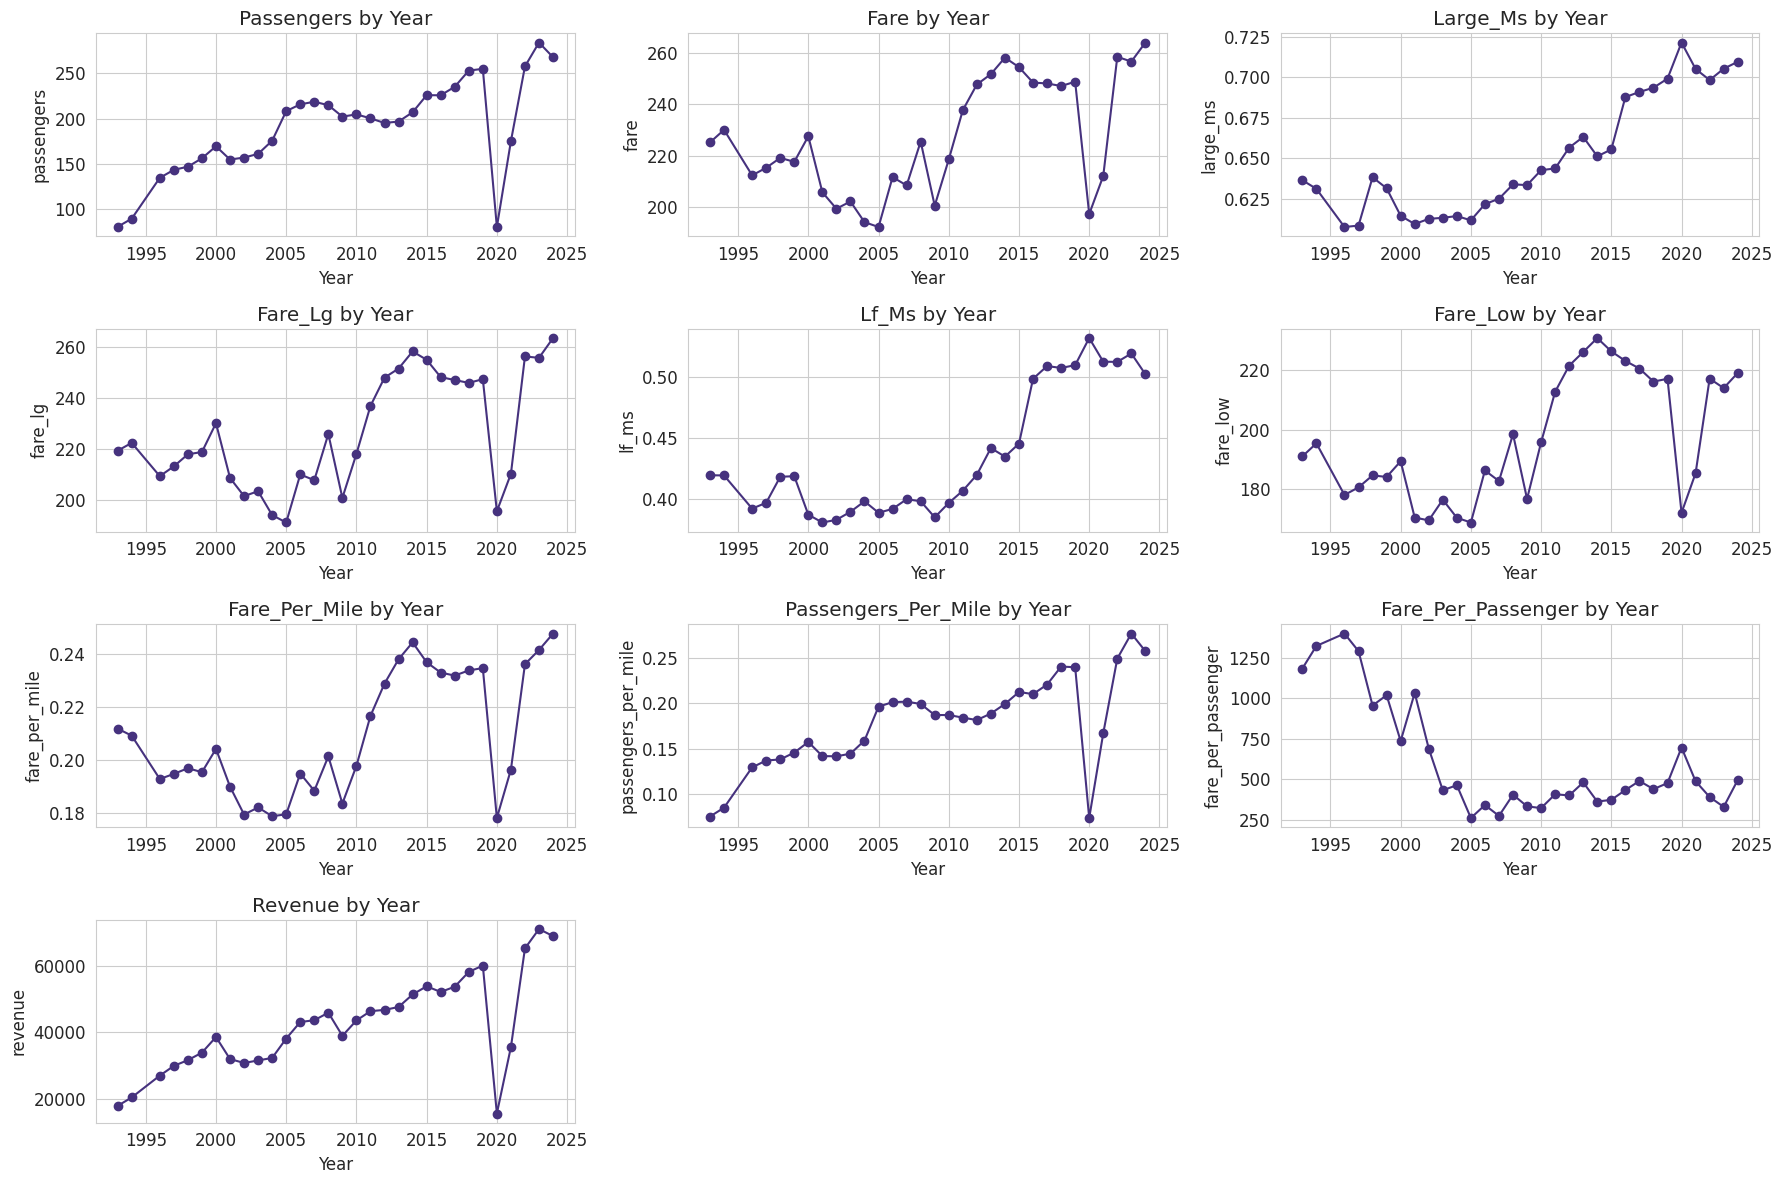



Section 2: Plotting distribution of categorical columns
Skipped 'city1': 140 unique values
Skipped 'city2': 126 unique values
Skipped 'airport_1': 159 unique values
Skipped 'airport_2': 144 unique values
Skipped 'carrier_lg': 62 unique values
Skipped 'carrier_low': 63 unique values
Skipped 'Geocoded_City1': 233 unique values
Skipped 'Geocoded_City2': 203 unique values


Section 3: Plotting frequency of values in 'possible_airlines'


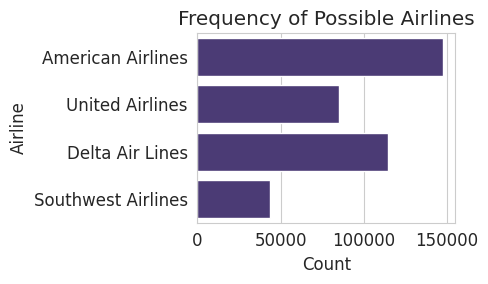



Section 4: Plotting correlation heatmap for numerical variables


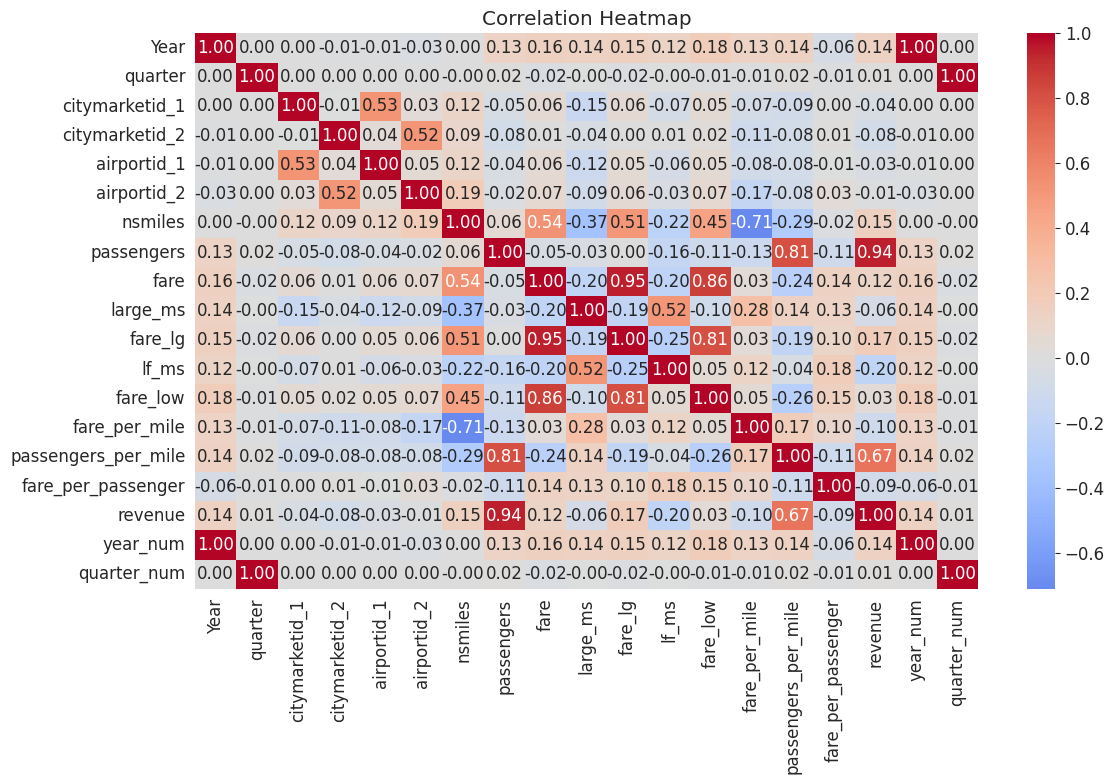



Section 5: Plotting passenger volume over time by top 5 origin airports


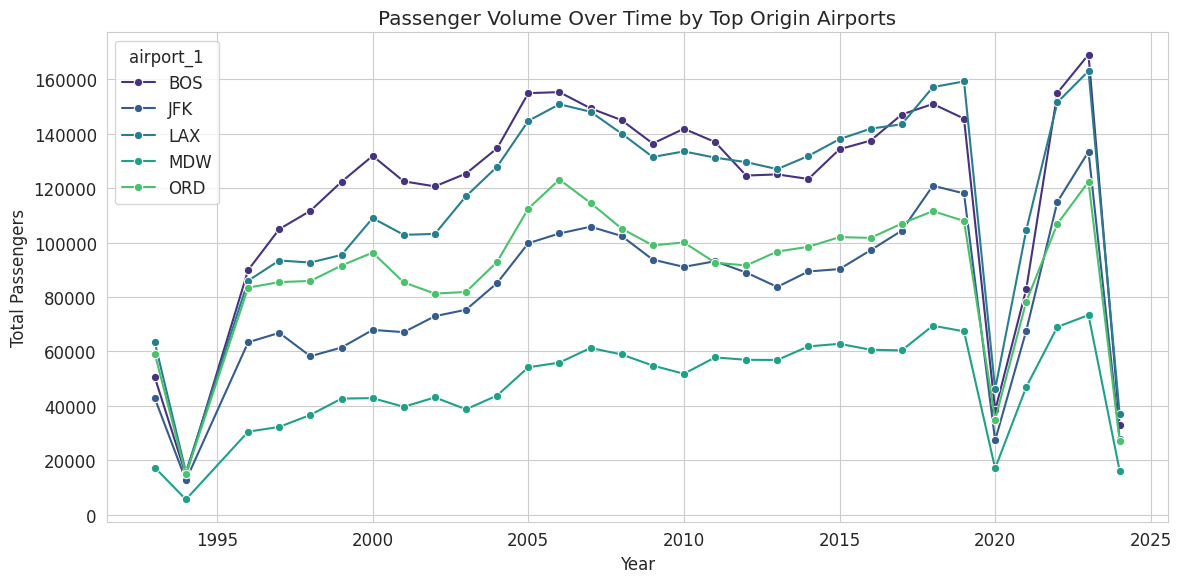



Section 6: Plotting average fare over time by top carriers


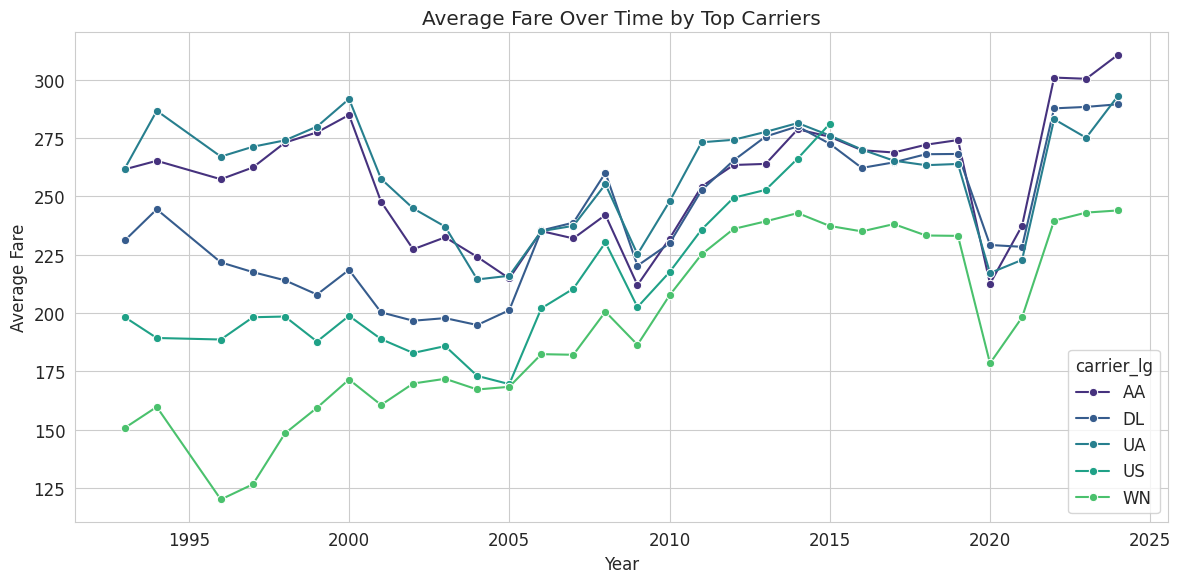



Section 7: Plotting heatmap of top 25 origin-destination pairs by flight count


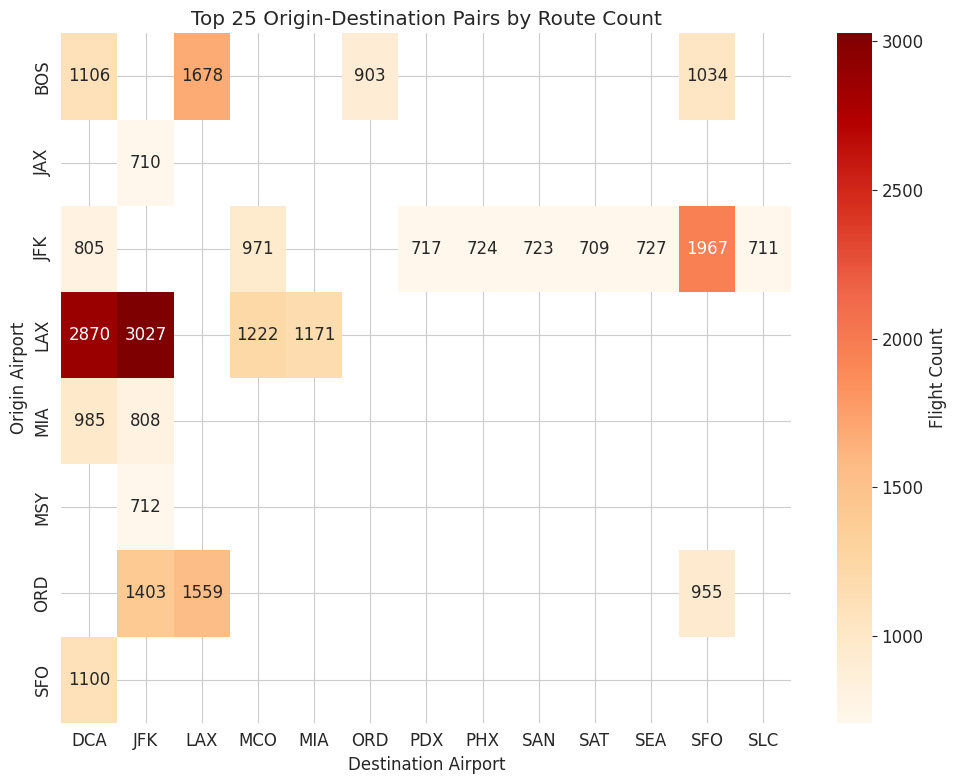



Section 8: Plotting quarterly revenue trend


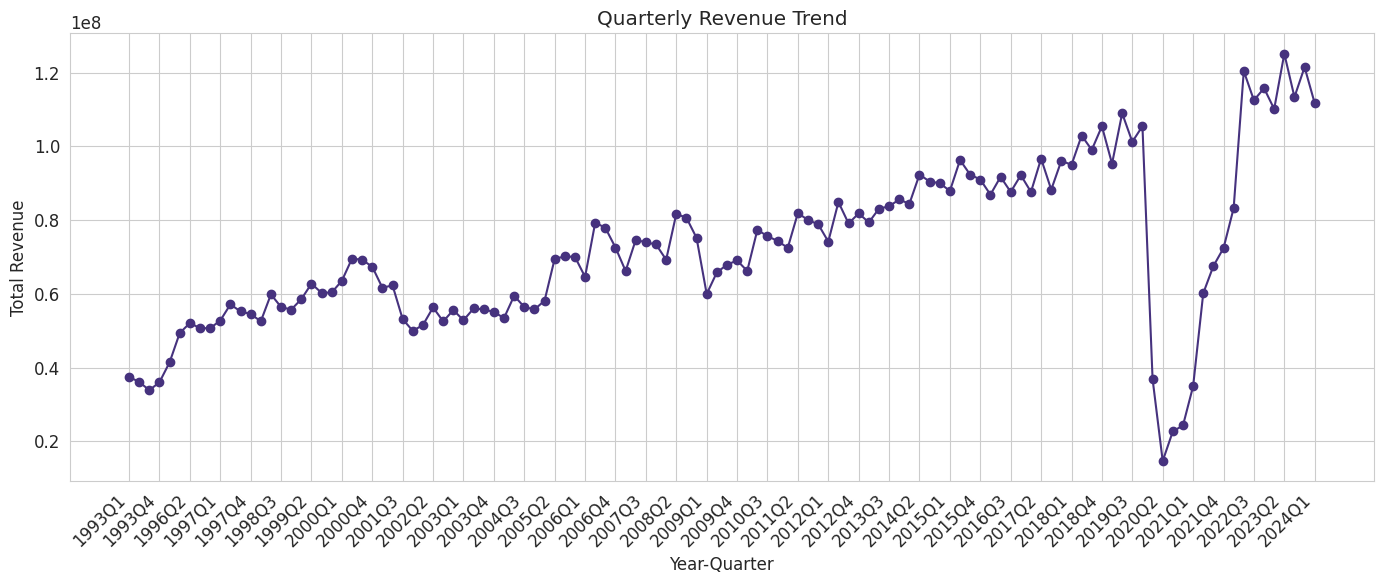

In [4]:
def plot_distributions_by_year(df, columns, year_col='Year', ncols=3, figsize=(18, 12)):
    """Plot distribution of numerical columns grouped by year."""
    if year_col not in df.columns:
        raise ValueError(f"'{year_col}' column not found in DataFrame.")

    df = df.copy()

    # Ensure year is integer
    if not np.issubdtype(df[year_col].dtype, np.integer):
        df[year_col] = df[year_col].astype(int)

    nrows = (len(columns) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    i = 0
    for i, col in enumerate(columns):
        if col in df.columns and col.lower() not in ['year', 'quarter']:
            grouped = df.groupby(year_col)[col].mean().dropna()
            if len(grouped) > 1:
                axes[i].plot(grouped.index, grouped.values, marker='o')
                axes[i].set_title(f'{col.title()} by Year')
                axes[i].set_xlabel('Year')
                axes[i].set_ylabel(col)
                axes[i].grid(True)
            else:
                axes[i].text(0.5, 0.5, 'Not enough data to plot', ha='center', va='center')
                axes[i].set_title(f'{col.titl()} by Year')
                axes[i].axis('off')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


# ---------------------------------------
# 1. Plot numerical feature trends by year
# ---------------------------------------
print("\n\nSection 1: Plotting numerical column distributions by year")
columns_to_plot = [
    'passengers', 'fare', 'large_ms', 'fare_lg', 'lf_ms', 'fare_low',
    'fare_per_mile', 'passengers_per_mile', 'fare_per_passenger', 'revenue'
]
plot_distributions_by_year(df_clean, columns_to_plot)

# ---------------------------------------
# 2. Plot distribution of categorical columns
# ---------------------------------------
print("\n\nSection 2: Plotting distribution of categorical columns")
cat_cols = [
    col for col in df_clean.select_dtypes(include=['object']).columns
    if not df_clean[col].apply(lambda x: isinstance(x, list)).any()
]

for col in cat_cols:
    unique_vals = df_clean[col].nunique()
    if unique_vals < 60:
        plt.figure(figsize=(10, 6))
        sns.countplot(y=col, data=df_clean,
                      order=df_clean[col].value_counts().index)
        plt.title(f'Distribution of {col} ({unique_vals} categories)')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipped '{col}': {unique_vals} unique values")

# ---------------------------------------
# 3. Plot frequency of possible airlines
# ---------------------------------------
print("\n\nSection 3: Plotting frequency of values in 'possible_airlines'")
flattened = list(chain.from_iterable(df_clean['possible_airlines']))
airline_counts = Counter(flattened)
plt.figure(figsize=(5, 3))
sns.barplot(x=list(airline_counts.values()), y=list(airline_counts.keys()))
plt.title('Frequency of Possible Airlines')
plt.xlabel('Count')
plt.ylabel('Airline')
plt.tight_layout()
plt.show()

# ---------------------------------------
# 4. Correlation heatmap
# ---------------------------------------
print("\n\nSection 4: Plotting correlation heatmap for numerical variables")
plt.figure(figsize=(12, 8))
corr = df_clean.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# ---------------------------------------
# 5. Passenger volume over time by top 5 origin airports
# ---------------------------------------
print("\n\nSection 5: Plotting passenger volume over time by top 5 origin airports")
top_airports = df_clean['airport_1'].value_counts().nlargest(5).index
filtered = df_clean[df_clean['airport_1'].isin(top_airports)]

grouped = (
    filtered.groupby(['Year', 'airport_1'])['passengers']
    .sum()
    .reset_index()
)
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped, x='Year', y='passengers', hue='airport_1', marker='o')
plt.title('Passenger Volume Over Time by Top Origin Airports')
plt.xlabel('Year')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------
# 6. Average fare by top carriers
# ---------------------------------------
print("\n\nSection 6: Plotting average fare over time by top carriers")
top_carriers = df_clean['carrier_lg'].value_counts().nlargest(5).index
filtered = df_clean[df_clean['carrier_lg'].isin(top_carriers)]

grouped = (
    filtered.groupby(['Year', 'carrier_lg'])['fare']
    .mean()
    .reset_index()
)
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped, x='Year', y='fare', hue='carrier_lg', marker='o')
plt.title('Average Fare Over Time by Top Carriers')
plt.xlabel('Year')
plt.ylabel('Average Fare')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------
# 7. Heatmap of top origin-destination pairs
# ---------------------------------------
print("\n\nSection 7: Plotting heatmap of top 25 origin-destination pairs by flight count")
od_counts = df_clean.groupby(['airport_1', 'airport_2']).size().reset_index(name='count')
top_pairs = od_counts.sort_values('count', ascending=False).head(25)

# Pivot for heatmap
pivot = top_pairs.pivot(index='airport_1', columns='airport_2', values='count')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='OrRd', cbar_kws={'label': 'Flight Count'})
plt.title('Top 25 Origin-Destination Pairs by Route Count')
plt.xlabel('Destination Airport')
plt.ylabel('Origin Airport')
plt.tight_layout()
plt.show()

# ---------------------------------------
# 8. Quarterly revenue trend
# ---------------------------------------
print("\n\nSection 8: Plotting quarterly revenue trend")
quarterly_revenue = (
    df_clean.groupby('period')['revenue']
    .sum()
    .reset_index()
    .sort_values('period')
)

plt.figure(figsize=(14, 6))
plt.plot(
        quarterly_revenue['period'].astype(str),
         quarterly_revenue['revenue'],
         marker='o'
)
tick_positions = range(0, len(quarterly_revenue), 3)
plt.xticks(
    tick_positions,
    quarterly_revenue['period'].astype(str).iloc[tick_positions],
    rotation=45,
    ha='right'
)

plt.title('Quarterly Revenue Trend')
plt.xlabel('Year-Quarter')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()

## Profit Margin vs. Revenue by Distance Bucket (2018–2024)

To evaluate profitability across different route lengths, we calculated revenue, cost estimates, and profit margins for all flights between 2018 and 2024.  
Revenue was computed as `fare × passengers`, while costs were approximated at \$0.10 per passenger-mile flown. Profit was defined as `revenue – cost_estimate`, and profit margin as `profit ÷ revenue`.

Routes were grouped into six **distance buckets**:

- 0-500 mi  
- 501-1000 mi  
- 1001-1500 mi  
- 1501-2000 mi  
- 2001-2500 mi  
- 2501-3000 mi  

Average revenue, profit, and profit margin were then aggregated within each bucket to identify which route lengths deliver the strongest returns.  
The results showed that **shorter routes (0–500 mi)** had the highest average profit margins, with profitability decreasing steadily as route distance increased.

**Figure X**  
*Average profit margin by distance bucket for U.S. airline routes from 2018 to 2024.* The vertical bar chart shows that shorter routes yield the highest average margins, while longer routes are less profitable on average.  

*Note.* Data sourced from the U.S. Airline Fare dataset (Kaggle). Profit margins are calculated as average revenue minus estimated costs (at \$0.10 per passenger-mile), expressed as a proportion of revenue, and aggregated within each distance range.


Profit Margin vs Revenue by Distance Bucket (2018–2024):


,distance_bucket,revenue,profit,profit_margin
0,0-500mi,54094.331883,42081.722733,0.787653
1,501-1000mi,71120.035667,41804.389480,0.590501
2,1001-1500mi,78613.771320,34181.210997,0.425519
3,1501-2000mi,78960.918641,26144.220223,0.312403
4,2001-2500mi,73026.937312,17418.181316,0.204803
5,2501-3000mi,111432.534484,29588.396478,0.105513


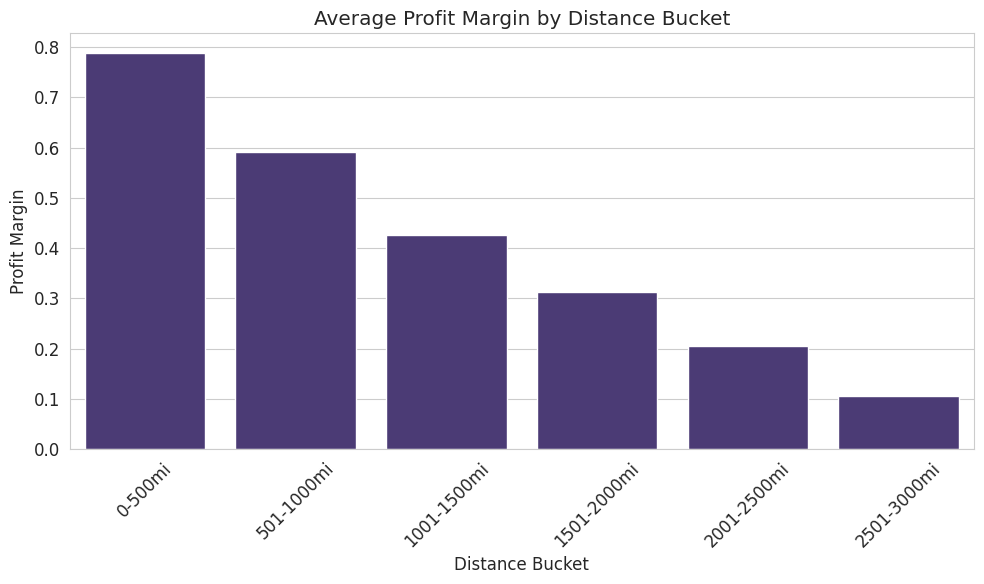

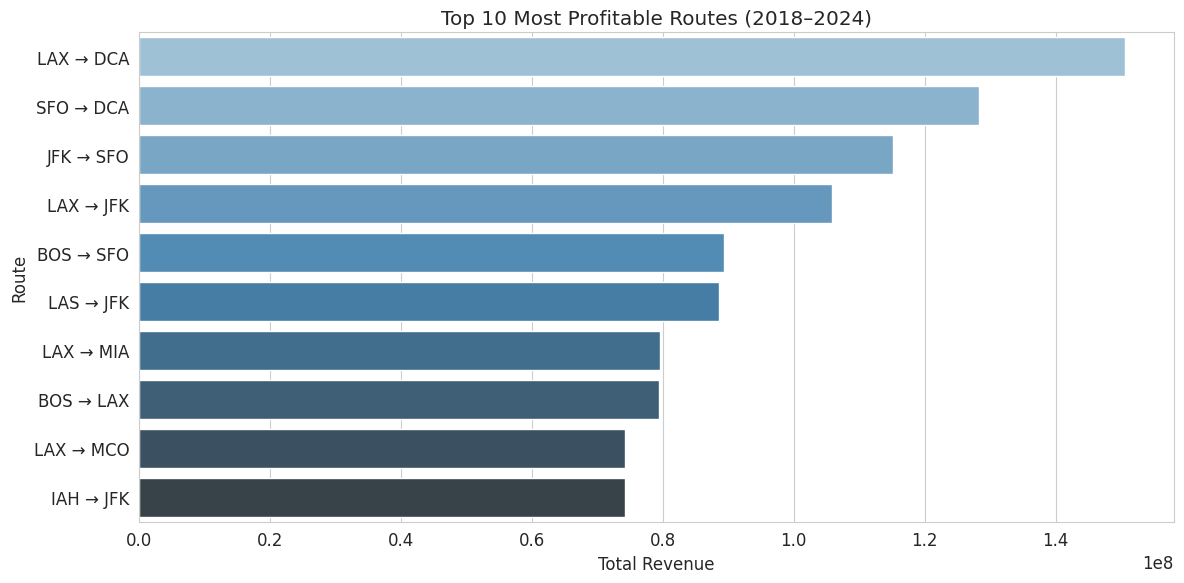

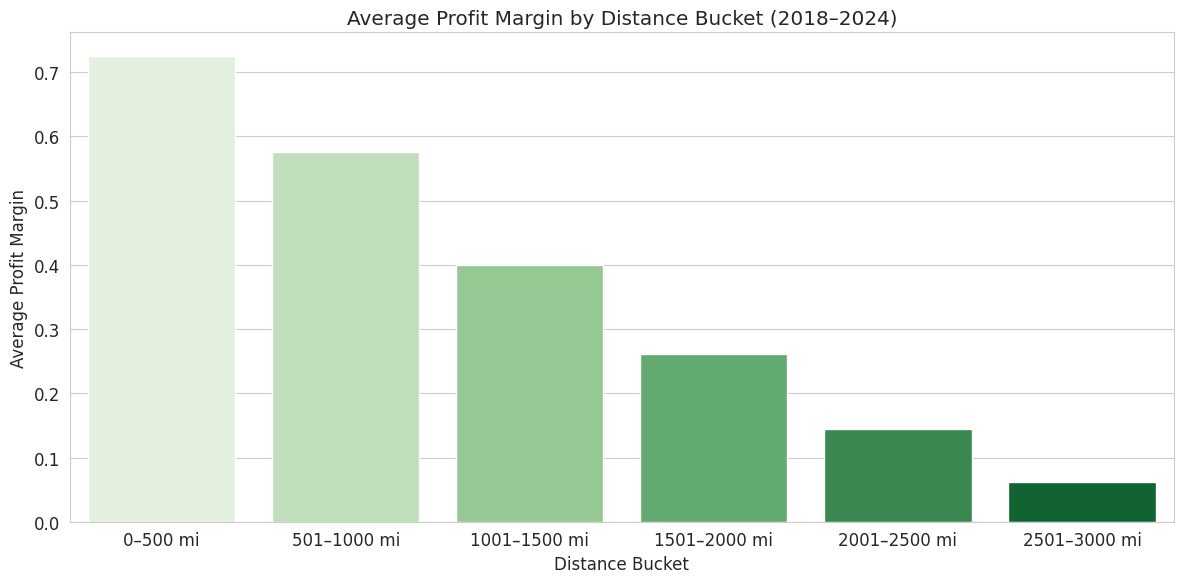

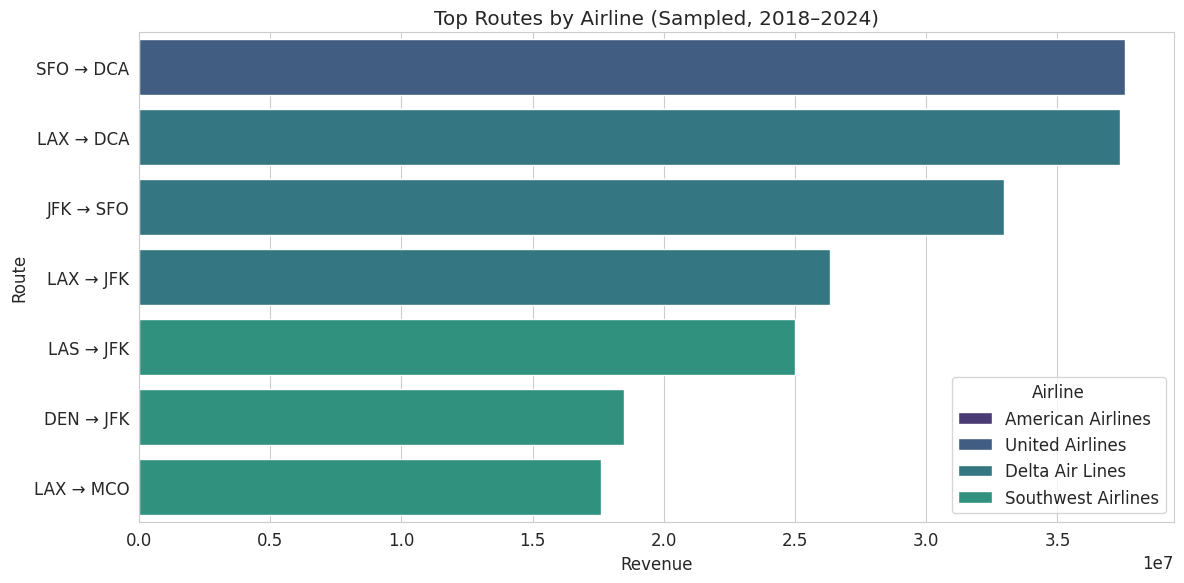

In [5]:
# Profit Margin vs Revenue by Distance Bucket (2018–2024)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume your cleaned DataFrame is named 'data'
df_filtered = data[(data['Year'] >= 2018) & (data['Year'] <= 2024)].copy()

# Calculate revenue and cost estimates
df_filtered['revenue'] = df_filtered['fare'] * df_filtered['passengers']
df_filtered['cost_estimate'] = df_filtered['nsmiles'] * df_filtered['passengers'] * 0.10  # Approximate $0.10 per mile
df_filtered['profit'] = df_filtered['revenue'] - df_filtered['cost_estimate']
df_filtered['profit_margin'] = df_filtered['profit'] / df_filtered['revenue']

# Group by distance buckets as proxy for route clusters
df_filtered['distance_bucket'] = pd.cut(
    df_filtered['nsmiles'],
    bins=[0, 500, 1000, 1500, 2000, 2500, 3000],
    labels=['0-500mi', '501-1000mi', '1001-1500mi', '1501-2000mi', '2001-2500mi', '2501-3000mi']
)

# Aggregate by bucket
route_profit_df = df_filtered.groupby('distance_bucket')[['revenue', 'profit', 'profit_margin']].mean().reset_index()
route_profit_df = route_profit_df.sort_values(by='profit_margin', ascending=False)

# Display the result
print("Profit Margin vs Revenue by Distance Bucket (2018–2024):")
display(route_profit_df)

# Optional: visualize
plt.figure(figsize=(10,6))
sns.barplot(data=route_profit_df, x='distance_bucket', y='profit_margin')
plt.title('Average Profit Margin by Distance Bucket')
plt.ylabel('Profit Margin')
plt.xlabel('Distance Bucket')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


top_profit_routes = (
    df_clean.groupby(['airport_1', 'airport_2'])['revenue']
    .sum()
    .reset_index()
    .sort_values(by='revenue', ascending=False)
    .head(10)
)
top_profit_routes['route'] = top_profit_routes['airport_1'] + ' → ' + top_profit_routes['airport_2']

plt.figure(figsize=(12, 6))
sns.barplot(data=top_profit_routes, x='revenue', y='route', palette='Blues_d')
plt.title("Top 10 Most Profitable Routes (2018–2024)")
plt.xlabel("Total Revenue")
plt.ylabel("Route")
plt.tight_layout()
plt.show()


df_clean['distance_bucket'] = pd.cut(
    df_clean['nsmiles'],
    bins=[0, 500, 1000, 1500, 2000, 2500, 3000],
    labels=['0–500 mi', '501–1000 mi', '1001–1500 mi', '1501–2000 mi', '2001–2500 mi', '2501–3000 mi']
)

df_clean['cost_estimate'] = df_clean['nsmiles'] * df_clean['passengers'] * 0.10
df_clean['profit'] = df_clean['revenue'] - df_clean['cost_estimate']
df_clean['profit_margin'] = df_clean['profit'] / df_clean['revenue']

profit_by_bucket = (
    df_clean.groupby('distance_bucket')['profit_margin']
    .mean()
    .reset_index()
    .sort_values(by='profit_margin', ascending=False)
)

plt.figure(figsize=(12, 6))
sns.barplot(data=profit_by_bucket, x='distance_bucket', y='profit_margin', palette='Greens')
plt.title("Average Profit Margin by Distance Bucket (2018–2024)")
plt.xlabel("Distance Bucket")
plt.ylabel("Average Profit Margin")
plt.tight_layout()
plt.show()

sampled_df = df_clean.dropna(subset=['possible_airlines']).sample(n=50000, random_state=42).explode('possible_airlines')

airline_perf = (
    sampled_df.groupby(['possible_airlines', 'airport_1', 'airport_2'])['revenue']
    .sum()
    .reset_index()
    .sort_values(by='revenue', ascending=False)
    .groupby('possible_airlines')
    .head(3)
)
airline_perf['route'] = airline_perf['airport_1'] + ' → ' + airline_perf['airport_2']

plt.figure(figsize=(12, 6))
sns.barplot(data=airline_perf, x='revenue', y='route', hue='possible_airlines', dodge=False)
plt.title("Top Routes by Airline (Sampled, 2018–2024)")
plt.xlabel("Revenue")
plt.ylabel("Route")
plt.legend(title="Airline")
plt.tight_layout()
plt.show()

top_airports = df_clean['airport_1'].value_counts().nlargest(10).index
top_carriers = df_clean['carrier_lg'].value_counts().nlargest(5).index

df_filtered = df_clean[
    df_clean['airport_1'].isin(top_airports) &
    df_clean['airport_2'].isin(top_airports) &  # restrict to top destinations too
    df_clean['carrier_lg'].isin(top_carriers)
]


df_filtered['year_quarter'] = df_filtered['Year'].astype(str) + 'Q' + df_filtered['quarter'].astype(str)
all_nodes = pd.unique(df_filtered[['airport_1', 'carrier_lg', 'airport_2']].values.ravel())
node_map = {label: i for i, label in enumerate(all_nodes)}

def build_links(yq):
    temp = df_filtered[df_filtered['year_quarter'] == yq]
    grouped = temp.groupby(['airport_1', 'carrier_lg', 'airport_2']).size().reset_index(name='count')

    links1 = pd.DataFrame({
        'source': grouped['airport_1'].map(node_map),
        'target': grouped['carrier_lg'].map(node_map),
        'value': grouped['count']
    })

    links2 = pd.DataFrame({
        'source': grouped['carrier_lg'].map(node_map),
        'target': grouped['airport_2'].map(node_map),
        'value': grouped['count']
    })

    return pd.concat([links1, links2])

quarters = sorted(df_filtered['year_quarter'].unique())
frames = []
for yq in quarters:
    links = build_links(yq)
    frames.append(go.Frame(
        data=[go.Sankey(
            node=dict(label=all_nodes),
            link=dict(
                source=links['source'],
                target=links['target'],
                value=links['value']
            )
        )],
        name=yq
    ))

initial_links = build_links(quarters[0])
fig = go.Figure(
    data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            label=all_nodes,
            line=dict(color="black", width=0.5)
        ),
        link=dict(
            source=initial_links['source'],
            target=initial_links['target'],
            value=initial_links['value']
        )
    )],
    layout=go.Layout(
        title_text="Quarterly Airport → Carrier → Airport Flow",
        font_size=10,
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play", method="animate", args=[None, {
                "frame": {"duration": 1000, "redraw": True},
                "fromcurrent": True, "transition": {"duration": 300}}])]
        )]
    ),
    frames=frames
)

fig.update_layout(sliders=[{
    "steps": [{"args": [[q], {"frame": {"duration": 500}, "mode": "immediate"}],
               "label": q, "method": "animate"} for q in quarters],
    "transition": {"duration": 100}, "x": 0.1, "xanchor": "left", "y": -0.2, "yanchor": "top"
}])

fig.show()

## Full Forecasting Pipeline: From Aggregation to Model Evaluation

This notebook section implements a comprehensive forecasting pipeline that supports both **machine learning (ML)** and **statistical (ARIMA/SARIMA)** models. The pipeline handles quarterly airline data, performs dynamic feature engineering, evaluates multiple configurations, and identifies the best-performing forecast model.

---

### Section Overview

**Section 1 – Data Aggregation & Feature Engineering**  
- `create_working_agg_df(df_clean)`:  
Aggregates raw airline data by quarter. Computes total passengers, revenue, mean fare, and derived metrics like log-revenue and revenue per passenger.
- `create_periods(train_start, train_end, test_start='2020Q1')`:  
Utility to define train/test periods using `pd.Period`.
- `create_ml_features(df, target_var, features)`:  
Generates lagged features, rolling averages, percentage chance, seasonal variables (`year`, `quarter`) based on the selected target variable.

**Section 2 – Model Evaluation & Scoring**  
Handles evaluation of predicting quality and scoring of model performance:
- `calculate_model_metrics(actual, predicted)`:  
Computes:
- MAPE (Mean Absolute Percentage Error)
- RMSE (Root Mean Squared Error)
- MAE (Mean Absolute Error)
- R² (Coefficient of Determination)
- Directional Accuracy (% of correct trend predictions)
- Aggregated Performance Score  
- `calculate_performance_score(mape, rmse, mae, r2, directional_accuracy)`:  
Custom scoring function using weighted normalization across key metrics.

**Section 3 – Data Splitting & Config Generation**  
- `split_data(df_feat, train_start_period, train_end_period, test_start_period)`:  
Splits time-indexed data into training and testing sets with minimum length checks.

`generate_test_configs()`:
Returns a list of all combinations of:
- Targets (`log_revenue`, `fare`, etc.)
- ML feature sets (e.g., `lag_1`, `rolling_mean_4`)
- Algorithms (`XGBoostRegression`, `RandomForest`, `ARIMA`)
- Training periods (e.g., 1993Q1–2019Q4)

**Section 4 – ARIMA Model Utilities**  
Tools to fit and evaluate statistical models (ARIMA/SARIMA):
- `fit_arima_model(train_data, target_var)`:  
Searches over ARIMA and SARIMA parameter grids using AIC to find the best model.
- `test_arima_model(...)`:  
Applies ARIMA to the specified configuration, generates forecasts, and returns evaluation metrics.

**Section 5 – Machine Learning Model Utilities**  
Handles ML model training, prediction, and evaluation:
- `test_ml_model(...)`:  
Trains and tests a regression model (`XGBoostRegression` and `RandomForestRegression`) using selected features and a time-based train/test split.

**Section 6 – Unified Testing & Execution Pipeline**  
Wraps model-specific logic and orchestrates testing across all configurations:
- `test_single_combination(...)`:  
Wraps ARIMA and ML testing logic behind a unified interface. Returns metrics, trained model, and features used.
- `test_high_combinations(agg_df, verbose_every=100)`:
Iterates over all configurations from `generate_test_configs()`, fits models, evaluates performance, and records results in `results_df`. Identifies and stores the best-performing model.

**Section 7 – Run the Forecasting Pipeline**  
Final cell to execute the full pipeline from raw input to best model discovery:
- Builds the aggregared dataset.
- Tests hundreds of ML and ARIMA configurations.
- Stores results, metrics, and the best trained model.
- Displays a forecast plot for the best-performing model automatically.

In [6]:
# Section 1: Data Aggregation and Preprocessing
def create_working_agg_df(df_clean):
    if 'period' not in df_clean.columns:
        df_clean = df_clean.copy()
        df_clean['period'] = pd.PeriodIndex(year=df_clean['Year'], quarter=df_clean['quarter'], freq='Q')
    agg_df = df_clean.groupby('period').agg({
        'fare': 'mean', 'passengers': 'sum', 'revenue': 'sum'
    }).sort_index()
    agg_df['log_revenue'] = np.log(agg_df['revenue'] + 1)
    agg_df['log_passengers'] = np.log(agg_df['passengers'] + 1)
    agg_df['revenue_per_passenger'] = agg_df['revenue'] / agg_df['passengers']
    print(f"agg_df: {agg_df.shape}, {agg_df.index.min()} to {agg_df.index.max()}")
    return agg_df

def create_periods(train_start, train_end, test_start, test_end):
    if test_start is None:
        test_start = '2020Q1'
    if test_end is None:
        test_end = '2024Q1'
    train_start_period = pd.Period(train_start, freq='Q')
    train_end_period = pd.Period(train_end, freq='Q')
    test_start_period = pd.Period(test_start, freq='Q')
    test_end_period = pd.Period(test_end, freq='Q')
    return train_start_period, train_end_period, test_start_period, test_end_period

def create_ml_features(df, target_var, features):
    """Create ML features for time series data"""
    df = df[[target_var]].copy()
    df['quarter'], df['year'] = df.index.quarter, df.index.year
    if 'lag_1' in features:
        df['lag_1'] = df[target_var].shift(1)
    if 'lag_2' in features:
        df['lag_2'] = df[target_var].shift(2)
    if 'lag_3' in features:
        df['lag_3'] = df[target_var].shift(3)
    if 'lag_4' in features:
        df['lag_4'] = df[target_var].shift(4)
    if 'lag_8' in features:
        df['lag_8'] = df[target_var].shift(8)
    if 'lag_12' in features:
        df['lag_12'] = df[target_var].shift(12)
    if 'lag_16' in features:
        df['lag_16'] = df[target_var].shift(16)
    if 'rolling_mean_4' in features:
        df['rolling_mean_4'] = df[target_var].shift(1).rolling(4).mean()
    if 'pct_change_1' in features:
        df['pct_change_1'] = df[target_var].pct_change(1)
    df['y'] = df[target_var]
    return df.dropna()

# Section 2: Evaluation and Scoring
def calculate_performance_score(mape, rmse, mae, r2, directional_accuracy):
    norm_mape = min(mape, 1000) / 1000
    norm_rmse = min(rmse, 1000) / 1000
    norm_mae = min(mae, 1000) / 1000
    norm_r2 = max(0, r2)
    norm_da = directional_accuracy / 100
    weights = {
        'mape': 0.25, 'rmse': 0.2, 'mae': 0.1, 'r2': 0.25, 'da': 0.1
    }
    score = (
        weights['mape'] * (1 - norm_mape) +
        weights['rmse'] * (1 - norm_rmse) +
        weights['mae'] * (1 - norm_mae) +
        weights['r2'] * norm_r2 +
        weights['da'] * norm_da
    )
    return score

def calculate_model_metrics(actual, predicted):
    mask = ~(np.isnan(actual) | np.isnan(predicted))
    actual_clean = actual[mask]
    predicted_clean = predicted[mask]
    if len(actual_clean) == 0:
        return {'MAPE': float('inf'), 'RMSE': float('inf'), 'MAE': float('inf'),
                'R2': -float('inf'), 'Directional_Accuracy': 0, 'Performance_Score': -float('inf')}
    non_zero_mask = actual_clean != 0
    if np.sum(non_zero_mask) > 0:
        mape = np.mean(np.abs((actual_clean[non_zero_mask] - predicted_clean[non_zero_mask]) / actual_clean[non_zero_mask])) * 100
    else:
        mape = float('inf')
    rmse = np.sqrt(np.mean((actual_clean - predicted_clean) ** 2))
    mae = np.mean(np.abs(actual_clean - predicted_clean))
    r2 = r2_score(actual_clean, predicted_clean)
    if len(actual_clean) > 1:
        actual_direction = np.sign(np.diff(actual_clean))
        pred_direction = np.sign(np.diff(predicted_clean))
        directional_accuracy = np.mean(actual_direction == pred_direction) * 100
    else:
        directional_accuracy = 0
    performance_score = calculate_performance_score(mape, rmse, mae, r2, directional_accuracy)
    return {'MAPE': mape, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'Directional_Accuracy': directional_accuracy, 'Performance_Score': performance_score}

# Section 3: Train/test Splitting and Configs
def split_data(df_feat, train_start_period, train_end_period, test_start_period):
    train_mask, test_mask = (df_feat.index >= train_start_period) & (df_feat.index <= train_end_period), df_feat.index >= test_start_period
    train_data, test_data = df_feat[train_mask], df_feat[test_mask]
    # if len(train_data) < 20 or len(test_data) < 4:
    #     raise ValueError("Insufficient data")
    return train_data, test_data

def generate_test_configs(train_end='2019Q4'):
    ml_targets = ['log_revenue', 'log_passengers', 'fare', 'revenue_per_passenger']
    arima_targets = ml_targets + ['revenue', 'passengers']
    starts = ['1993Q1', '1997Q1', '2000Q1', '2005Q1', '2008Q1', '2013Q1']
    starts_filtered = [s for s in starts if pd.Period(s, freq='Q') < pd.Period(train_end, freq='Q')]
    train_periods = [(start, train_end) for start in starts_filtered]
    ml_feature_combinations = [
        ['year', 'quarter', 'lag_1', 'lag_4', 'rolling_mean_4', 'pct_change_1'],
        ['quarter', 'lag_1', 'lag_4', 'rolling_mean_4'],
        ['year', 'quarter', 'lag_1'],
        ['quarter', 'lag_1', 'pct_change_1'],
        ['quarter', 'lag_1', 'rolling_mean_4'],
        ['lag_4', 'lag_8', 'lag_16'],
        ['lag_4', 'lag_16', 'pct_change_1'],

        ['lag_1', 'lag_2', 'lag_3', 'lag_4'],
        ['lag_1', 'lag_4', 'rolling_mean_4'],
        ['year', 'quarter', 'lag_1', 'lag_4', 'lag_8', 'lag_16'],

        ['year', 'quarter', 'lag_1', 'pct_change_1', 'rolling_mean_4'],
        ['lag_1', 'lag_4', 'pct_change_1', 'rolling_mean_4'],
        ['lag_4', 'lag_16'],
        ['quarter', 'lag_1', 'lag_4'],
        ['year', 'quarter', 'lag_1', 'lag_4'],
        ['lag_1', 'lag_4'],
        ['quarter', 'pct_change_1'],
        ['lag_1', 'pct_change_1'],
    ]
    configs = []
    for train_start_period, train_end_period in train_periods:
        for model in ['XGBoostRegression', 'RandomForest']:
            for target in ml_targets:
                for features in ml_feature_combinations:
                    configs.append((target, features, model, train_start_period, train_end))
        for target in arima_targets:
            configs.append((target, ['ARIMA_auto'], 'ARIMA', train_start_period, train_end))
    return configs

# Section 4: ARIMA/SARIMA Modeling
def fit_arima_model(train_data, target_var):
    ts = train_data[target_var]
    arima_configs = [(p, d, q, None) for p in range(3) for d in range(2) for q in range(3)]
    sarima_configs = [
        (p, d, q, (P, D, Q, 4))
        for p in range(2) for d in range(2) for q in range(2)
        for P in range(2) for D in range(2) for Q in range(2)
        if not (P == 0 and D == 0 and Q == 0)
    ]

    best_aic = float('inf')
    best_model = None
    best_order = None
    best_seasonal = None

    for p, d, q, seasonal_order in arima_configs + sarima_configs:
        try:
            model = ARIMA(ts, order=(p, d, q), seasonal_order=seasonal_order) if seasonal_order else ARIMA(ts, order=(p, d, q))
            fitted = model.fit()
            if fitted.aic < best_aic:
                best_aic = fitted.aic
                best_model = fitted
                best_order = (p, d, q)
                best_seasonal = seasonal_order
        except Exception:
            continue

    if best_model:
        if best_seasonal:
            P, D, Q, s = best_seasonal
            best_model_name = f"SARIMA{best_order}({P},{D},{Q},{s})"
        else:
            best_model_name = f"ARIMA{best_order}"
        return best_model, best_model_name
    else:
        fallback_model = ARIMA(ts, order=(1, 1, 1)).fit()
        return fallback_model, "ARIMA(1,1,1)"

def test_arima_model(
    agg_df, target_var, features, train_start, train_end, test_start='2020Q1', test_end='2024Q1',
    test_index=None, verbose_every=None
):
    train_start_period, train_end_period, test_start_period, test_end_period = create_periods(
        train_start, train_end, test_start=test_start, test_end=test_end
    )
    ts_data = agg_df[[target_var]].copy()
    train_data, test_data = split_data(ts_data, train_start_period, train_end_period, test_start_period)

    arima_model, model_name = fit_arima_model(train_data, target_var)
    forecast = arima_model.forecast(steps=len(test_data))
    metrics = calculate_model_metrics(test_data[target_var].values, forecast)
    if verbose_every is None or (test_index is not None and test_index % verbose_every == 0):
        test_prefix = f"Test {test_index}: " if test_index else ""
        print(f"  {test_prefix}Best model for {target_var}: {model_name}, MAPE: {metrics['MAPE']:.1f}%, RMSE: {metrics['RMSE']:.1f}, R²: {metrics['R2']:.3f}")
    return metrics, arima_model, ts_data

# Section 5: Machine Learning Models
def test_ml_model(agg_df, target_var, features, model_type, train_start, train_end,
                  test_start='2020Q1', test_end='2024Q1', test_index=None, verbose_every=None):
    train_start_period, train_end_period, test_start_period, test_end_period = create_periods(
        train_start, train_end, test_start=test_start, test_end=test_end
    )
    df_feat = create_ml_features(agg_df, target_var, features)
    train_data, test_data = split_data(df_feat, train_start_period, train_end_period, test_start_period)
    X_train, y_train = train_data[features], train_data['y']
    X_test, y_test = test_data[features], test_data['y']
    if model_type == 'XGBoostRegression':
        model = XGBRegressor(n_estimators=200, max_depth=3, random_state=42)
    elif model_type == 'RandomForest':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    else:
        raise ValueError("Invalid model type")
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    metrics = calculate_model_metrics(y_test.values, pred)
    if verbose_every is None or (test_index is not None and test_index % verbose_every == 0):
        test_prefix = f"Test {test_index}: " if test_index else ""
        print(f"  {test_prefix}Best model for {target_var}: {model_type}[{'+'.join(features)}], MAPE: {metrics['MAPE']:.1f}%, R²: {metrics['R2']:.3f}")
    return metrics, model, df_feat

# Section 6: Pipeline Wrappers
def test_single_combination(
    agg_df, target_var, features, model_type,
    train_start, train_end,
    test_start=None, test_end=None,
    test_index=None, total_tests=None, verbose_every=100
):
    if model_type == 'ARIMA':
        metrics, model, df_feat = test_arima_model(
            agg_df, target_var, features, train_start, train_end,
            test_start=test_start, test_end=test_end,
            test_index=test_index, verbose_every=verbose_every
        )
    else:
        metrics, model, df_feat = test_ml_model(
            agg_df, target_var, features, model_type, train_start, train_end,
            test_start=test_start, test_end=test_end,
            test_index=test_index, verbose_every=verbose_every
        )
    return metrics, model, df_feat

def plot_forecast(model, df_feat, target_var, features, model_type,
                  train_start, train_end, test_start, test_end):
    train_start_period, train_end_period, test_start_period, test_end_period = create_periods(
        train_start, train_end, test_start, test_end
    )

    test_mask = (df_feat.index >= test_start_period) & (df_feat.index <= test_end_period)
    train_mask = (df_feat.index >= train_start_period) & (df_feat.index <= train_end_period)

    if model_type == 'ARIMA':
        y_train = df_feat.loc[train_mask, target_var]
        y_test = df_feat.loc[test_mask, target_var]
        y_pred = model.forecast(steps=len(y_test))
    else:
        X_train = df_feat.loc[train_mask, features]
        y_train = df_feat.loc[train_mask, 'y']
        X_test = df_feat.loc[test_mask, features]
        y_test = df_feat.loc[test_mask, 'y']
        y_pred = model.predict(X_test)

    # Plotting
    plt.figure(figsize=(14, 6))
    plt.plot(y_train.index.to_timestamp(), y_train, label='Train Actual', color='blue')
    plt.plot(y_test.index.to_timestamp(), y_test, label='Test Actual', color='green')
    plt.plot(y_test.index.to_timestamp(), y_pred, label='Test Predicted', color='red', linestyle='--')
    plt.title(f'{model_type} Forecast of {target_var}\nTrain: {train_start}–{train_end}, Test: {test_start}–{test_end}')
    plt.xlabel('Date')
    plt.ylabel(target_var)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def test_high_combinations(
    agg_df,
    verbose_every=100,
    train_end='2019Q4',
    test_start='2020Q1',
    test_end='2024Q1',
    target_variable=None   # new parameter, default None (means run all)
):
    results, models = [], {}
    test_configs = generate_test_configs(train_end=train_end)

    # Filter test_configs if target_variable is specified
    if target_variable is not None:
        test_configs = [cfg for cfg in test_configs if cfg[0] == target_variable]

    print(f"Testing {len(test_configs)} configurations for target variable: {target_variable if target_variable else 'all'}...")
    for i, (target_var, features, model_type, train_start, train_end) in enumerate(test_configs):
        try:
            metrics, model, df_feat = test_single_combination(
                agg_df, target_var, features, model_type,
                train_start, train_end,
                test_start=test_start, test_end=test_end,
                test_index=i + 1, total_tests=len(test_configs),
                verbose_every=verbose_every
            )
            config_name = f"{model_type}_{target_var}_{'+'.join(features)}_{train_start}-{train_end}"
            results.append({
                'Config': config_name,
                'Target': target_var,
                'Features': features,
                'Model': model_type,
                'Train_Period': f"{train_start}-{train_end}",
                'MAPE': metrics['MAPE'],
                'RMSE': metrics['RMSE'],
                'MAE': metrics['MAE'],
                'R2': metrics['R2'],
                'Directional_Accuracy': metrics['Directional_Accuracy'],
                'Performance_Score': metrics['Performance_Score']
            })
            models[config_name] = {
                'model': model,
                'df_feat': df_feat,
                'target_var': target_var,
                'features': features,
                'metrics': metrics
            }
            if (i + 1) % verbose_every == 0:
                print(f"  {i+1:2d}/{len(test_configs)} configs tested...")
        except Exception as e:
            if model_type == 'ARIMA':
                print(f"  ARIMA failed for {target_var} {features[0]}: {str(e)[:50]}")
            continue

    if not results:
        print("No successful configurations to evaluate.")
        return None, None, None

    results_df = pd.DataFrame(results)
    best_config = results_df.loc[results_df['Performance_Score'].idxmax()]
    best_model_info = models[best_config['Config']]

    print(f"\nBest: {best_config['Config']}")
    print(f"MAPE = {best_config['MAPE']:.1f}%, R² = {best_config['R2']:.3f}, Directional Accuracy = {best_config['Directional_Accuracy']:.1f}%")

    # Extract info for plotting
    model = best_model_info['model']
    df_feat = best_model_info['df_feat']
    target_var = best_model_info['target_var']
    features = best_model_info['features']
    model_type = best_config['Model']
    train_start, train_end = best_config['Train_Period'].split('-')

    plot_forecast(
        model, df_feat, target_var, features,
        model_type, train_start, train_end,
        test_start, test_end
    )

    return best_config, best_model_info, results_df

agg_df: (118, 6), 1993Q1 to 2024Q1
Testing 222 configurations for target variable: log_revenue...
  Test 50: Best model for log_revenue: XGBoostRegression[lag_4+lag_16], MAPE: 1.7%, R²: 0.011
  50/222 configs tested...
  Test 100: Best model for log_revenue: RandomForest[lag_1+lag_2+lag_3+lag_4], MAPE: 1.5%, R²: 0.355
  100/222 configs tested...
  Test 150: Best model for log_revenue: XGBoostRegression[quarter+lag_1+lag_4+rolling_mean_4], MAPE: 1.6%, R²: 0.168
  150/222 configs tested...
  Test 200: Best model for log_revenue: XGBoostRegression[year+quarter+lag_1+lag_4], MAPE: 1.7%, R²: 0.002
  200/222 configs tested...

Best: XGBoostRegression_log_revenue_quarter+lag_1+pct_change_1_1993Q1-2013Q4
MAPE = 1.3%, R² = 0.612, Directional Accuracy = 90.0%


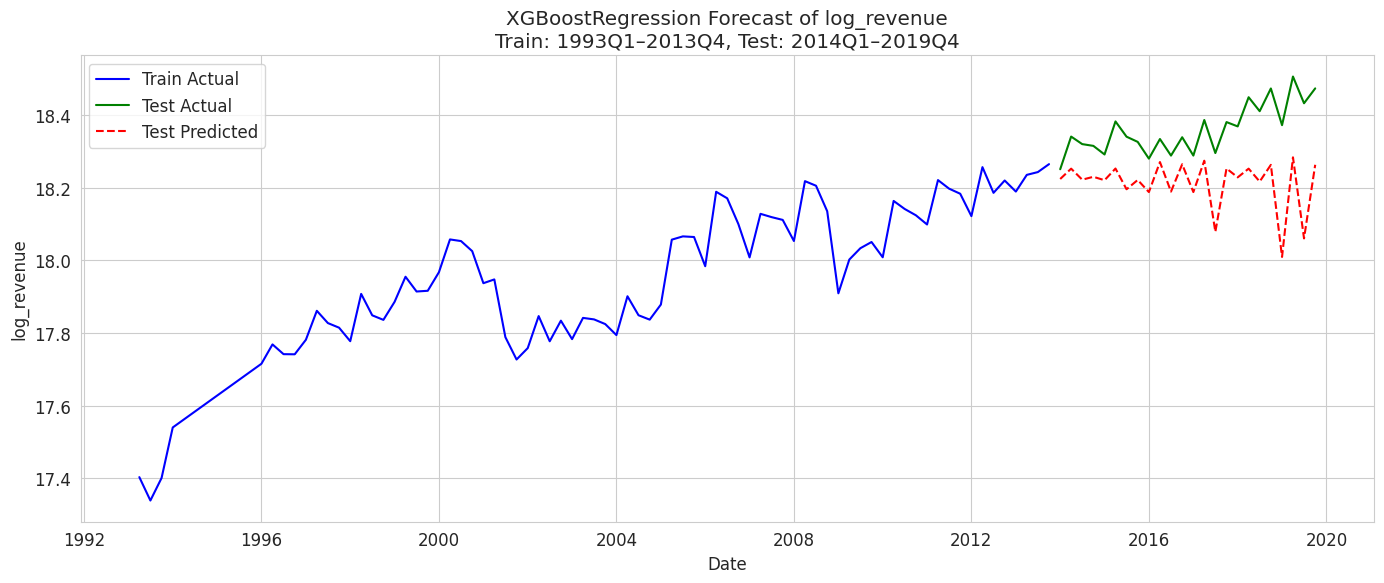

In [7]:
# Section 7: Run pipeline
agg_df = create_working_agg_df(df_clean)
best_config, best_model_info, results_df = test_high_combinations(
    agg_df,
    verbose_every=50,
    train_end='2013Q4', # 2019Q4 is the default
    test_start='2014Q1', # 2020Q1 is the default
    test_end='2019Q4', # 2024Q1 is the default
    target_variable = 'log_revenue'
)

### Forecast Generation Using Best Model

This section defines the logic for generating multi-step forecasts using either classical time series models (e.g., ARIMA) or machine learning models (e.g., Random Forest, XGBoost).

In [8]:
# Section 11: Forecast with best model
def create_forecast_features(features, next_quarter, next_year, forecasts, i, current_value, recent_values):
    """Create feature dictionary for forecasting"""
    feature_dict = {}
    if 'quarter' in features: feature_dict['quarter'] = next_quarter
    if 'year' in features: feature_dict['year'] = next_year
    if 'lag_1' in features: feature_dict['lag_1'] = forecasts[i-1] if i > 0 else current_value
    if 'lag_4' in features: feature_dict['lag_4'] = forecasts[i-4] if i >= 4 else recent_values[-(4-i)] if i < 4 else recent_values[-4]
    if 'lag_16' in features: feature_dict['lag_16'] = forecasts[i-16] if i >= 16 else recent_values[-(16-i)] if i < 16 else recent_values[-1]
    if 'rolling_mean_4' in features:
        feature_dict['rolling_mean_4'] = np.mean((recent_values + forecasts[:i])[-4:]) if i > 0 else np.mean(recent_values[-4:])
    if 'pct_change_1' in features:
        prev_value = forecasts[i-1] if i > 0 else recent_values[-1]
        current_pred_value = forecasts[i-1] if i > 0 else current_value
        feature_dict['pct_change_1'] = (current_pred_value - prev_value) / prev_value if prev_value != 0 else 0
    return feature_dict

def generate_forecast_with_best(agg_df, best_config, best_model_info, periods=8):
    model, target_var, features = best_model_info['model'], best_model_info['target_var'], best_model_info['features']
    if hasattr(model, 'forecast') and features[0] == 'ARIMA_auto':
        forecasts = model.forecast(steps=periods)
        if target_var.startswith('log_'): forecasts = np.exp(forecasts) - 1
        forecasts = list(forecasts)
    else:
        forecasts, current_value = [], agg_df[target_var].iloc[-1]
        last_quarter, last_year = agg_df.index.max().quarter, agg_df.index.max().year
        recent_values = list(agg_df[target_var].iloc[-8:])
        for i in range(periods):
            next_quarter = ((last_quarter + i - 1) % 4) + 1
            next_year = last_year + (last_quarter + i - 1) // 4
            feature_dict = create_forecast_features(features, next_quarter, next_year, forecasts, i, current_value, recent_values)
            pred_df = pd.DataFrame([feature_dict])[features]
            forecasts.append(model.predict(pred_df)[0])
    if target_var == 'log_revenue':
        if not (hasattr(model, 'forecast') and features[0] == 'ARIMA_auto'):
            forecasts = [np.exp(f) - 1 for f in forecasts]
        revenue_forecasts = forecasts
    elif target_var == 'revenue':
        revenue_forecasts = forecasts
    else:
        current_revenue = agg_df['revenue'].iloc[-1]
        current_target = agg_df[target_var].iloc[-1]
        conversion_ratio = current_revenue / current_target if current_target != 0 else 1
        revenue_forecasts = [f * conversion_ratio for f in forecasts]
    return revenue_forecasts

In [9]:
# Performance analysis
print("\nModel Performance by Type:")
for model_type in ['XGBoostRegression', 'RandomForest', 'ARIMA']:
    model_results = results_df[results_df['Model'] == model_type].sort_values('Performance_Score', ascending=False)
    if len(model_results) > 0:
        best_model = model_results.iloc[0]
        print(f"\n{model_type}:")
        print(f"  Best MAPE: {best_model['MAPE']:.1f}%")
        print(f"  Best R²: {best_model['R2']:.3f}")
        print(f"  Best Directional Accuracy: {best_model['Directional_Accuracy']:.1f}%")
        print(f"  Best Config: {best_model['Config']}")
        if len(model_results) > 1:
            print(f"  Top 3 MAPE scores: {model_results['MAPE'].head(3).tolist()}")
            print(f"  Top 3 R² scores: {model_results['R2'].head(3).tolist()}")

forecasts = generate_forecast_with_best(agg_df, best_config, best_model_info)

current_revenue = agg_df['revenue'].iloc[-1]
forecast_final = forecasts[-1]
annual_growth = ((forecast_final / current_revenue) ** 0.5 - 1) * 100


Model Performance by Type:

XGBoostRegression:
  Best MAPE: 1.3%
  Best R²: 0.612
  Best Directional Accuracy: 90.0%
  Best Config: XGBoostRegression_log_revenue_quarter+lag_1+pct_change_1_1993Q1-2013Q4
  Top 3 MAPE scores: [1.2948001211290143, 1.3196522640352844, 1.3145343543636883]
  Top 3 R² scores: [0.6119750741867623, 0.5930147652241541, 0.5393295825289939]

RandomForest:
  Best MAPE: 1.3%
  Best R²: 0.597
  Best Directional Accuracy: 92.5%
  Best Config: RandomForest_log_revenue_lag_1+pct_change_1_1993Q1-2013Q4
  Top 3 MAPE scores: [1.32639950261742, 1.3389378384411965, 1.433984559395083]
  Top 3 R² scores: [0.5974947815516861, 0.5967123646789136, 0.4631703115190138]

ARIMA:
  Best MAPE: 1.8%
  Best R²: 0.006
  Best Directional Accuracy: 85.0%
  Best Config: ARIMA_log_revenue_ARIMA_auto_2000Q1-2013Q4
  Top 3 MAPE scores: [1.797457454512353, 1.8183577230619516, 1.7775688810885675]
  Top 3 R² scores: [0.0060008332061965985, 0.005465398780392872, 0.010328583513880774]


### Model Performance Comparison by Feature Combinations and Target Variables

This section visualizes model performance across different feature engineering strategies, target variables, and model types.

---

#### Feature Combination Analysis

We evaluate how different feature sets perform across multiple models using the following metrics:

- **MAPE** (Mean Absolute Percentage Error) – Lower is better
- **MAE** (Mean Absolute Error) – Lower is better
- **R²** (Coefficient of Determination) – Higher is better
- **Directional Accuracy** – Percentage of correct trend direction (higher is better)

For each `(Feature Combination, Model)` pair:
- The **best-performing configuration** is selected based on each metric.
- Feature combinations are stringified for display purposes.
- Results are visualized using grouped bar plots for each metric.

These plots help identify:
- Which features are consistently useful across models
- Which model–feature combos yield the best results for different metrics

#### Target Variable Analysis

We also visualize **model performance across target variables**:

- For each `(Target, Model)` pair, the configuration with the **lowest MAPE** is retained.
- A grouped bar chart displays the best MAPE achieved per target variable and model.

This view is helpful for:
- Comparing model behavior across different forecasting targets (e.g., `fare`, `log_revenue`, etc.)
- Highlighting which targets are easier or harder to forecast

#### Scatter Plots: Directional Accuracy vs. MAPE

We plot each model configuration in a **2D space** of:

- X-axis: MAPE (%)
- Y-axis: Directional Accuracy (%)

Two versions are plotted:
- **All models**, including ARIMA
- **Filtered**, excluding ARIMA models (to focus on supervised ML models)

In [10]:
def prepare_feature_columns(df):
    if 'Features_str' not in df.columns:
        df['Features_str'] = df['Features'].apply(
            lambda x: ', '.join(x) if isinstance(x, list) else str(x)
        )
    return df

def shorten_features_string(s, maxlen=30):
    return s if len(s) <= maxlen else s[:maxlen] + '...'

def prepare_short_features(df):
    df['Features_short'] = df['Features'].apply(
        lambda x: shorten_features_string(', '.join(x)) if isinstance(x, list) else str(x)
    )
    return df

# --- Plot best metric grouped by (Features, Model) ---
def plot_best_metric_by_features(results_df, metric, maximize=True, use_short_labels=False):
    results_df = prepare_feature_columns(results_df)
    if use_short_labels:
        results_df = prepare_short_features(results_df)
        label_col = 'Features_short'
    else:
        label_col = 'Features_str'

    grouped = results_df.groupby([label_col, 'Model'])[metric]
    idx = grouped.idxmax() if maximize else grouped.idxmin()
    idx = idx.dropna()
    best_df = results_df.loc[idx.values]

    plt.figure(figsize=(14, 7))
    sns.barplot(data=best_df, x=label_col, y=metric, hue='Model')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Best {metric} by Feature Combination and Model')
    plt.ylabel(metric)
    plt.xlabel('Feature Combination')
    plt.legend(title='Model', loc='upper right')
    plt.tight_layout()
    plt.show()

# --- Plot best metric grouped by (Target, Model) ---
def plot_best_metric_by_target(results_df, metric='MAPE', maximize=False):
    grouped = results_df.groupby(['Target', 'Model'])[metric]
    idx = grouped.idxmax() if maximize else grouped.idxmin()
    idx = idx.dropna()
    best_df = results_df.loc[idx.values]

    plt.figure(figsize=(12, 6))
    sns.barplot(data=best_df, x='Target', y=metric, hue='Model')
    plt.title(f'Best {metric} by Target Variable and Model Type')
    plt.ylabel(f'Best {metric}')
    plt.xlabel('Target Variable')
    plt.xticks(rotation=45)
    plt.legend(title='Model Type')
    plt.tight_layout()
    plt.show()

# --- Scatter plot: Directional Accuracy vs MAPE ---
def scatter_directional_accuracy_vs_mape(results_df, exclude_arima=False, annotate_thresholds=True):
    df = results_df.copy()
    if exclude_arima:
        df = df[~df['Model'].str.contains('ARIMA')]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df,
        x='MAPE',
        y='Directional_Accuracy',
        hue='Model',
        style='Target' if exclude_arima else 'Model',
        palette='Set2' if exclude_arima else None,
        s=100 if not exclude_arima else 80,
        alpha=0.7
    )
    title = 'Directional Accuracy vs. MAPE'
    if exclude_arima:
        title += ' (Non-ARIMA Models)'
    plt.title(title)
    plt.xlabel('MAPE (%)')
    plt.ylabel('Directional Accuracy (%)')

    if annotate_thresholds:
        plt.axvline(x=5, color='gray', linestyle='--', linewidth=0.8)
        plt.axhline(y=50, color='gray', linestyle='--', linewidth=0.8)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

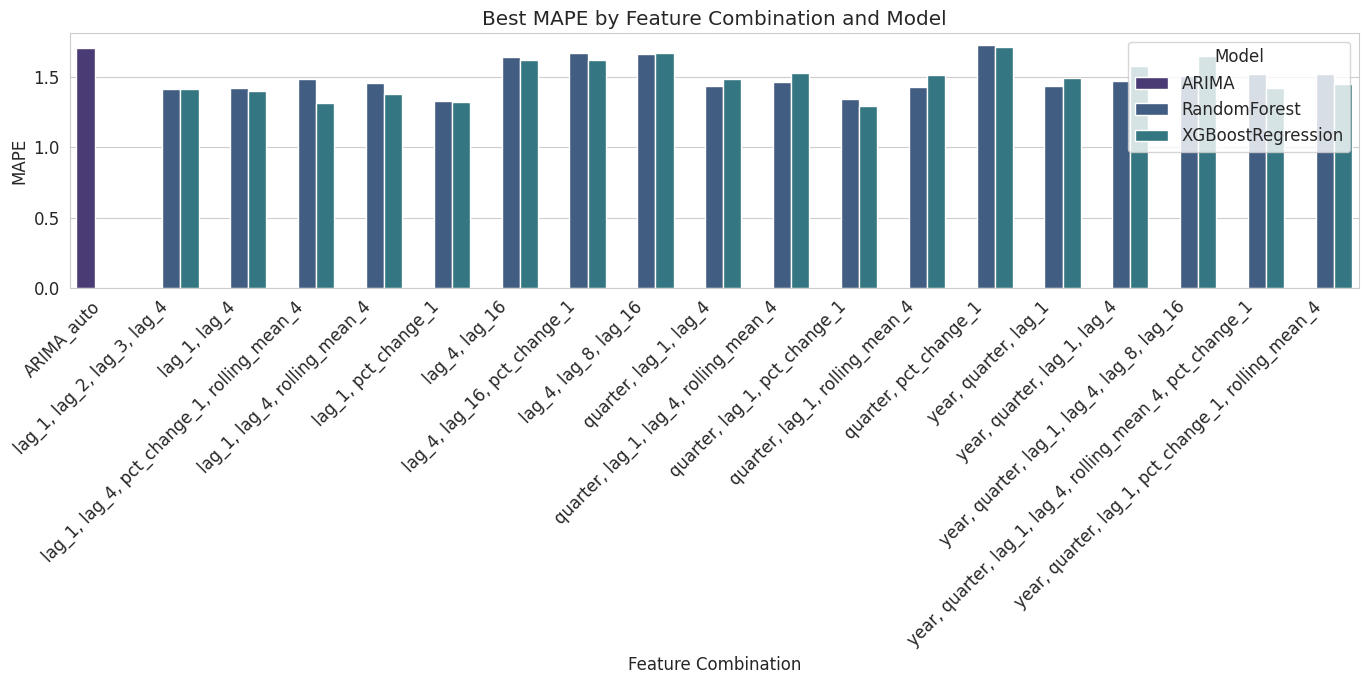

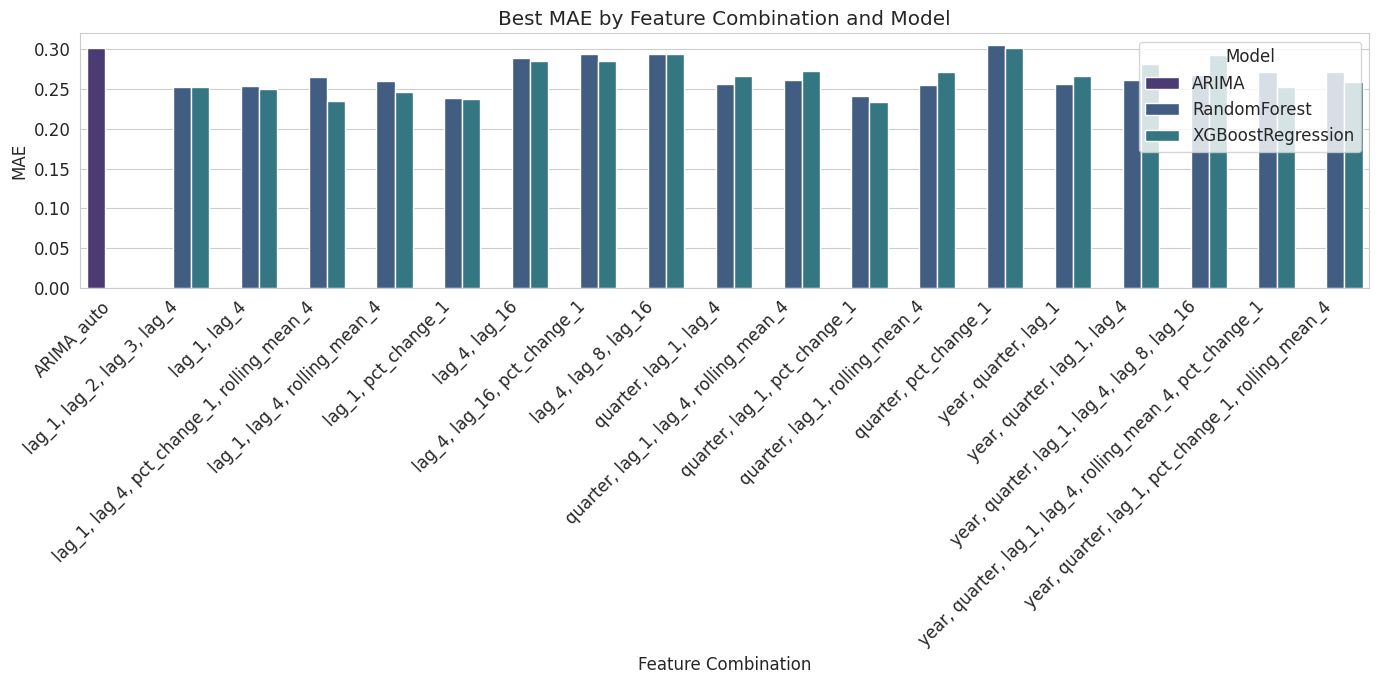

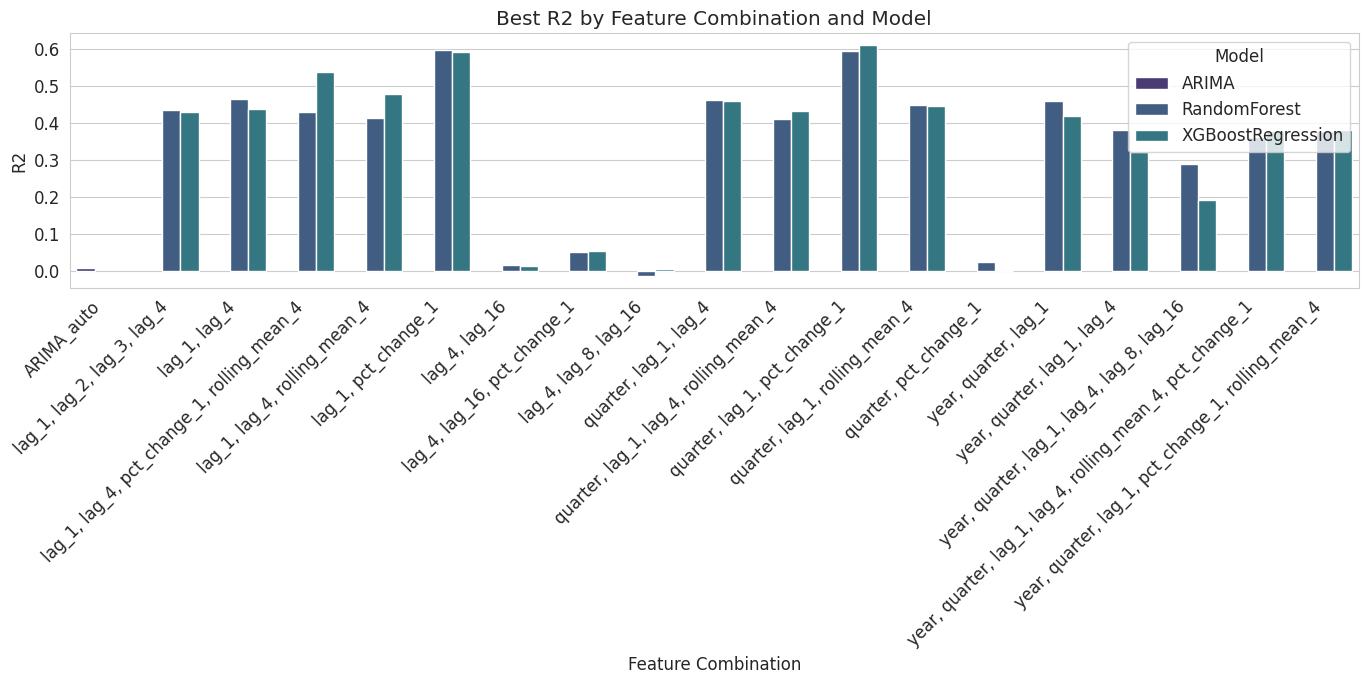

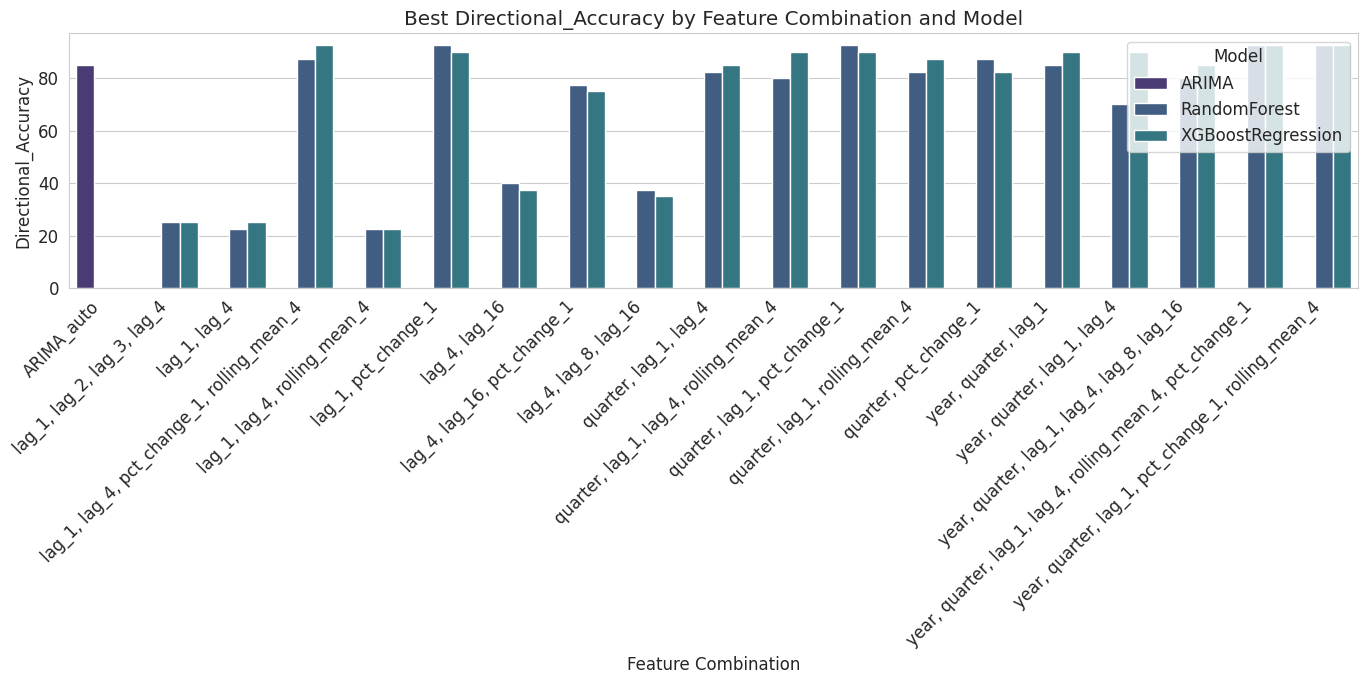

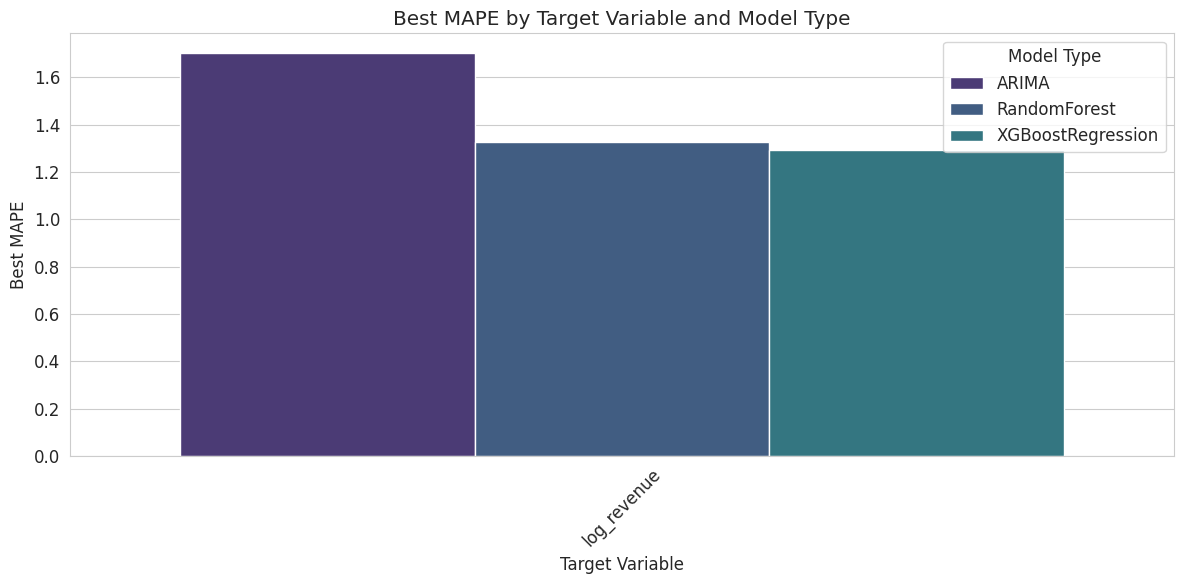

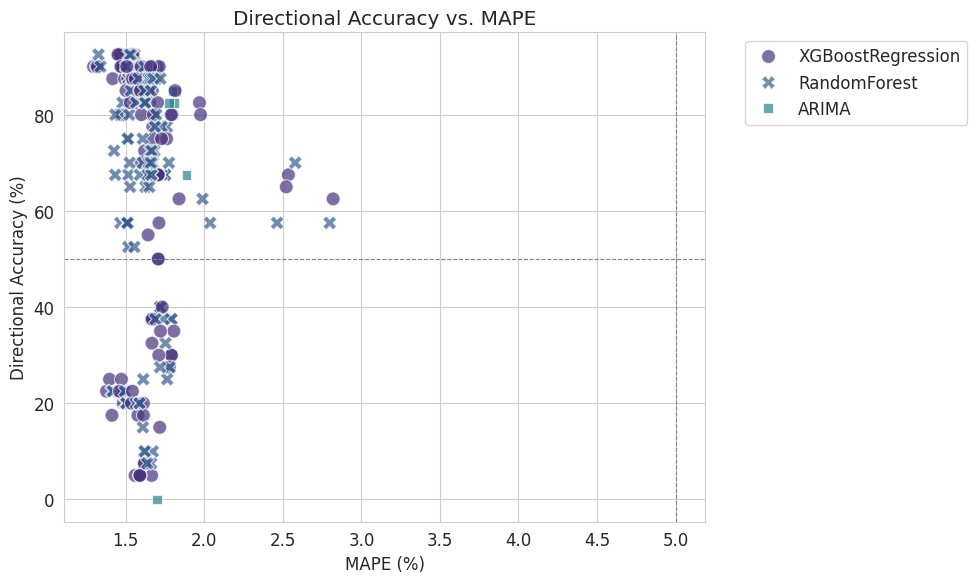

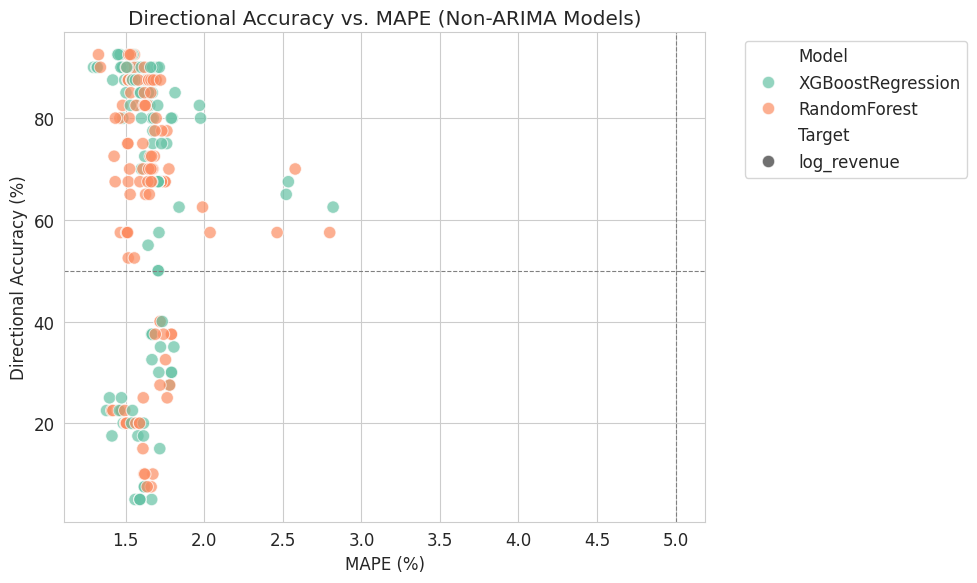

In [11]:
# Plot best metrics per feature+model group
plot_best_metric_by_features(results_df, metric='MAPE', maximize=False)
plot_best_metric_by_features(results_df, metric='MAE', maximize=False)
plot_best_metric_by_features(results_df, metric='R2', maximize=True)
plot_best_metric_by_features(results_df, metric='Directional_Accuracy', maximize=True)

# Plot best metrics per target+model group
plot_best_metric_by_target(results_df, metric='MAPE', maximize=False)

# Scatter plots: Directional Accuracy vs. MAPE
scatter_directional_accuracy_vs_mape(results_df, exclude_arima=False)
scatter_directional_accuracy_vs_mape(results_df, exclude_arima=True)


In [12]:
def print_top_configurations(results_df, metric='MAPE', top_n=10):
    """Print top configurations in table format"""

    metric_info = {
        'MAPE': {'ascending': True, 'format': '.2f', 'label': 'MAPE (%)'},
        'R2': {'ascending': False, 'format': '.2f', 'label': 'R²'},
        'Directional_Accuracy': {'ascending': False, 'format': '.1f', 'label': 'Dir_Acc (%)'},
        'RMSE': {'ascending': True, 'format': '.0f', 'label': 'RMSE'},
        'MAE': {'ascending': True, 'format': '.2f', 'label': 'MAE'},
        'Performance_Score': {'ascending': False, 'format': '.2f', 'label': 'Perf_Score'}
    }

    ascending = metric_info[metric]['ascending']

    top_results = results_df.sort_values(metric, ascending=ascending).head(top_n).copy()

    top_results['Short_Config'] = (
        top_results['Model'].str.replace('Regression', '').str.replace('Forest', 'F') + '_' +
        top_results['Target'] + '_' +
        top_results['Features'].apply(lambda x: '+'.join(x)) + '_' +
        top_results['Train_Period'].str[:]
    )

    if metric == 'MAPE':
        display_cols = ['Short_Config', 'MAPE', 'R2', 'Directional_Accuracy']
        col_labels = ['Configuration', 'MAPE (%)', 'R²', 'Dir_Acc (%)']
    elif metric == 'R2':
        display_cols = ['Short_Config', 'R2', 'MAPE', 'Directional_Accuracy']
        col_labels = ['Configuration', 'R²', 'MAPE (%)', 'Dir_Acc (%)']
    else:
        display_cols = ['Short_Config', metric, 'MAPE', 'R2']
        col_labels = ['Configuration', metric_info[metric]['label'], 'MAPE (%)', 'R²']

    table = top_results[display_cols].copy()
    table.columns = col_labels

    for col in table.columns[1:]:
        table[col] = table[col].round(2)

    table.index = range(1, len(table) + 1)

    sort_direction = "Ascending" if ascending else "Descending"
    print(f"\n{'='*90}")
    print(f"TOP {top_n} BY {metric.upper()} ({sort_direction})")
    print('='*90)
    print(table.to_string(index=True, index_names=['Rank']))
    print('='*90)

def print_best_accuracy(results_df, top_n=10):
    print_top_configurations(results_df, 'MAPE', top_n)

def print_best_fit(results_df, top_n=10):
    print_top_configurations(results_df, 'R2', top_n)

def print_best_trends(results_df, top_n=10):
    print_top_configurations(results_df, 'Directional_Accuracy', top_n)

print_best_accuracy(results_df)
print_best_fit(results_df)
print_top_configurations(results_df, 'RMSE')


TOP 10 BY MAPE (Ascending)
                                                                             Configuration  MAPE (%)    R²  Dir_Acc (%)
1                             XGBoost_log_revenue_quarter+lag_1+pct_change_1_1993Q1-2013Q4      1.29  0.61         90.0
2                XGBoost_log_revenue_lag_1+lag_4+pct_change_1+rolling_mean_4_1993Q1-2013Q4      1.31  0.54         90.0
3                                     XGBoost_log_revenue_lag_1+pct_change_1_1993Q1-2013Q4      1.32  0.59         90.0
4                                     RandomF_log_revenue_lag_1+pct_change_1_1993Q1-2013Q4      1.33  0.60         92.5
5                             RandomF_log_revenue_quarter+lag_1+pct_change_1_1993Q1-2013Q4      1.34  0.60         90.0
6                             XGBoost_log_revenue_lag_1+lag_4+rolling_mean_4_1993Q1-2013Q4      1.38  0.48         22.5
7                                            XGBoost_log_revenue_lag_1+lag_4_1993Q1-2013Q4      1.40  0.44         25.0
8           

### Model Analysis: Forecasting with Regression Models and Custom Train/Test Periods

This section defines a flexible function to train, evaluate, and visualize forecasts using various regression models and hand-selected quarterly time windows for training and testing.

In [13]:
def create_ml_features(df, target_var, features):
    """Create ML features for time series data"""
    df = df[[target_var]].copy()
    df['quarter'], df['year'] = df.index.quarter, df.index.year
    if 'lag_1' in features:
        df['lag_1'] = df[target_var].shift(1)
    if 'lag_2' in features:
        df['lag_2'] = df[target_var].shift(2)
    if 'lag_3' in features:
        df['lag_3'] = df[target_var].shift(3)
    if 'lag_4' in features:
        df['lag_4'] = df[target_var].shift(4)
    if 'lag_8' in features:
        df['lag_8'] = df[target_var].shift(8)
    if 'lag_12' in features:
        df['lag_12'] = df[target_var].shift(12)
    if 'lag_16' in features:
        df['lag_16'] = df[target_var].shift(16)
    if 'rolling_mean_4' in features:
        df['rolling_mean_4'] = df[target_var].shift(1).rolling(4).mean()
    if 'pct_change_1' in features:
        df['pct_change_1'] = df[target_var].pct_change(1)
    df['y'] = df[target_var]
    return df.dropna()

def forecast_next_quarter(
    agg_df,
    target_var,
    features,
    train_start,
    train_end,
    model_type='XGBoostRegression'
):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.ensemble import RandomForestRegressor
    from xgboost import XGBRegressor

    # Create ML features
    df_feat = create_ml_features(agg_df, target_var, features)

    # Define training periods
    train_start_period = pd.Period(train_start, freq='Q')
    train_end_period = pd.Period(train_end, freq='Q')

    train_mask = (df_feat.index >= train_start_period) & (df_feat.index <= train_end_period)

    X_train = df_feat.loc[train_mask, features].dropna()
    y_train = df_feat.loc[X_train.index, 'y']

    if model_type == 'RandomForest':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif model_type == 'XGBoostRegression':
        model = XGBRegressor(n_estimators=200, max_depth=3, random_state=42)
    else:
        print(f"Unsupported model '{model_type}', defaulting to RandomForest.")
        model = RandomForestRegressor(n_estimators=100, random_state=42)

    model.fit(X_train, y_train)

    # Predict only the next quarter
    last_period = agg_df.index.max()
    next_period = pd.Period(last_period + 1, freq='Q')
    date = next_period.to_timestamp()
    year = date.year
    quarter = date.quarter

    def get_lag(offset):
        if len(df_feat) >= offset:
            return df_feat['y'].iloc[-offset]
        else:
            return np.nan

    lag_values = {
        'lag_1': get_lag(1),
        'lag_2': get_lag(2),
        'lag_3': get_lag(3),
        'lag_4': get_lag(4),
        'lag_8': get_lag(8),
        'lag_12': get_lag(12),
        'lag_16': get_lag(16),
    }

    rolling_mean_4 = (
        df_feat['y'].iloc[-4:].mean()
        if len(df_feat) >= 4
        else df_feat['y'].mean()
    )

    if len(df_feat) >= 2 and df_feat['y'].iloc[-2] != 0:
        pct_change_1 = (
            (df_feat['y'].iloc[-1] - df_feat['y'].iloc[-2]) / df_feat['y'].iloc[-2]
        )
    else:
        pct_change_1 = 0

    feature_row = {
        'year': year,
        'quarter': quarter,
        'rolling_mean_4': rolling_mean_4,
        'pct_change_1': pct_change_1,
        **lag_values,
    }

    X_pred = pd.DataFrame([feature_row], index=pd.PeriodIndex([next_period], freq='Q'))[features]

    if X_pred.isnull().values.any():
        print(f"Skipping prediction for {next_period} due to NaNs in features: {X_pred.to_dict(orient='records')[0]}")
        return agg_df[[target_var]]

    y_pred = model.predict(X_pred)[0]

    # Prepare output DataFrame combining historical and forecasted value
    future_df = pd.DataFrame({ 'y_pred': [y_pred] }, index=pd.PeriodIndex([next_period], freq='Q'))

    plot_df = pd.concat([
        agg_df[[target_var]].rename(columns={target_var: 'value'}),
        future_df.rename(columns={'y_pred': 'value'})
    ])

    plot_df.index = plot_df.index.to_timestamp()
    plot_df = plot_df[~plot_df.index.duplicated()].sort_index()

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(plot_df.index, plot_df['value'], label='Historical + Forecast', marker='o')
    plt.axvline(last_period.to_timestamp(), color='gray', linestyle='--', label='Forecast Start')
    plt.title(f'Forecast for {target_var} using {model_type} (Next Quarter)')
    plt.xlabel('Date')
    plt.ylabel(target_var)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return plot_df

agg_df: (118, 6), 1993Q1 to 2024Q1


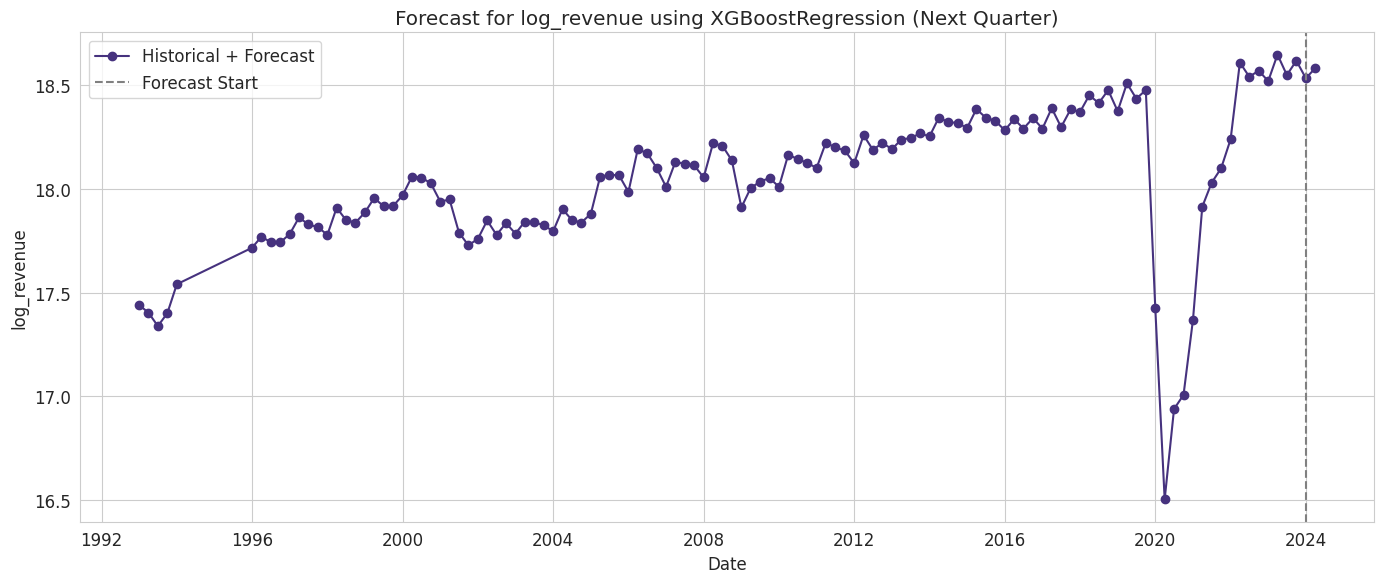

,value
1993-01-01,17.439545
1993-04-01,17.403071
1993-07-01,17.338662
1993-10-01,17.400706
1994-01-01,17.539875
...,...
2023-04-01,18.644686
2023-07-01,18.546065
2023-10-01,18.615205
2024-01-01,18.530992


In [14]:
def create_working_agg_df(df_clean):
    if 'period' not in df_clean.columns:
        df_clean = df_clean.copy()
        df_clean['period'] = pd.PeriodIndex(year=df_clean['Year'], quarter=df_clean['quarter'], freq='Q')
    agg_df = df_clean.groupby('period').agg({
        'fare': 'mean', 'passengers': 'sum', 'revenue': 'sum'
    }).sort_index()
    agg_df['log_revenue'] = np.log(agg_df['revenue'] + 1)
    agg_df['log_passengers'] = np.log(agg_df['passengers'] + 1)
    agg_df['revenue_per_passenger'] = agg_df['revenue'] / agg_df['passengers']
    print(f"agg_df: {agg_df.shape}, {agg_df.index.min()} to {agg_df.index.max()}")
    return agg_df

your_agg_df = create_working_agg_df(df_clean)

# Run the forecast for next quarter
forecast_next_quarter(
    agg_df=your_agg_df,
    target_var='log_revenue',
    features=['year', 'quarter', 'lag_1', 'lag_4', 'pct_change_1', 'rolling_mean_4'],
    train_start='2018Q1',
    train_end='2023Q4',
    model_type='XGBoostRegression'
)